In [ ]:
import numpy as np
import pandas as pd

In [ ]:
dataset = pd.read_csv("/content/thalassemia final dataset.csv")
dataset

Sl No              Age  Gender  HbA0  HbA2  HbF  S-Window   RBC    HB  \
0          1  14 Yrs 11 month       1  86.2   2.9  0.3       0.0  4.81  13.2   
1          2   16 Yrs 0 month       1  86.4   4.8  0.4       0.0  4.18  10.9   
2          3   16 Yrs 2 month       0  87.3   3.2  0.5       0.0  5.31  13.6   
3          4   21 Yrs 0 month       1  87.9   2.8  0.2       0.0  4.64  11.5   
4          5   35 Yrs 3 month       0  84.3   2.8  0.2       0.0  5.50  14.0   
...      ...              ...     ...   ...   ...  ...       ...   ...   ...   
13026  13027    1 Yrs 0 month       0  79.3   2.9  5.8       0.0  2.07   6.1   
13027  13028    1 Yrs 1 month       1  77.2   2.7  8.1       0.0  2.47   6.3   
13028  13029   1 Yrs 11 month       0  21.3  62.9  5.2       0.0  5.26  10.0   
13029  13030   1 Yrs 11 month       0  87.5   3.3  0.2       0.0  4.60  13.4   
13030  13031   34 Yrs 3 month       0  88.9   3.2  0.3       0.0  2.97   9.8   

        MCV   MCH  MCHC  RDWcv  Weekness  Jaundice  Diagnosis  
0      86.7  28.8  33.0   13.8       0.0       0.0          1  
1      78.9  26.1  33.0   14.6       0.0       0.0          2  
2      87.0  25.6  29.4   13.7       0.0       0.0          1  
3      78.7  44.8  31.5   14.5       0.0       0.0          1  
4      69.7  21.5  30.9   16.5       0.0       0.0          1  
...     ...   ...   ...    ...       ...       ...        ...  
13026  89.4  29.5  33.0   19.5       0.0       0.0          8  
13027  81.0  25.5  31.5   16.4       0.0       0.0          8  
13028  60.3  19.0  31.5   24.1       0.0       0.0         11  
13029  84.1  29.1  34.6   14.4       0.0       0.0          1  
13030  91.9  33.0  35.9   14.2       0.0       0.0          1  

[13031 rows x 16 columns]

In [ ]:
import pandas as pd
import re

# ---- Load your dataset ----
# dataset = pd.read_csv("your_file.csv")   # example

# ---- DROP Sl No / Serial Number COLUMN (IF EXISTS) ----
sl_cols = ['Sl No', 'SL No', 'S.No', 'S No', 'Serial No', 'Serial Number']

for col in sl_cols:
    if col in dataset.columns:
        dataset.drop(columns=[col], inplace=True)
        print(f"Dropped column: {col}")

# ---- Function to extract only years from mixed age strings ----
def extract_years(age_value):
    if pd.isna(age_value):
        return None
    age_str = str(age_value).lower()

    # Regex to capture only the year number
    match = re.search(r'(\d+)\s*(year|yr|years)?', age_str)
    if match:
        return int(match.group(1))
    return None

# ---- Apply function on Age column ----
dataset['Age'] = dataset['Age'].apply(extract_years)

# ---- If NaN exists, fill with median ----
dataset['Age'] = dataset['Age'].fillna(dataset['Age'].median())

# ---- Save new cleaned dataset ----
dataset.to_csv("cleaned_dataset.csv", index=False)

print("Dataset cleaned and saved as cleaned_dataset.csv")

# ---- Preview ----
dataset.head()


Dropped column: Sl No
Dataset cleaned and saved as cleaned_dataset.csv


Age  Gender  HbA0  HbA2  HbF  S-Window   RBC    HB   MCV   MCH  MCHC  \
0  14.0       1  86.2   2.9  0.3       0.0  4.81  13.2  86.7  28.8  33.0   
1  16.0       1  86.4   4.8  0.4       0.0  4.18  10.9  78.9  26.1  33.0   
2  16.0       0  87.3   3.2  0.5       0.0  5.31  13.6  87.0  25.6  29.4   
3  21.0       1  87.9   2.8  0.2       0.0  4.64  11.5  78.7  44.8  31.5   
4  35.0       0  84.3   2.8  0.2       0.0  5.50  14.0  69.7  21.5  30.9   

   RDWcv  Weekness  Jaundice  Diagnosis  
0   13.8       0.0       0.0          1  
1   14.6       0.0       0.0          2  
2   13.7       0.0       0.0          1  
3   14.5       0.0       0.0          1  
4   16.5       0.0       0.0          1

In [ ]:
X = dataset.drop('Diagnosis', axis=1)
y = dataset['Diagnosis']

APPLY ML MODEL XGBoost with CAON

In [ ]:
!pip install pyswarm

  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4463 sha256=371f63b0335f757dc2dcd707c7764386a371165c746d47f54ea466df5fc961b9
  Stored in directory: /root/.cache/pip/wheels/93/15/89/3970ef96abd6123028010a90f007c4e6a2bed700db0aa2d36a
Successfully built pyswarm


In [ ]:
best_accuracy = 0
best_model = None
best_params_global = None
best_fold = None

In [ ]:
# ===================== IMPORTS =====================
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, cohen_kappa_score
)
from pyswarm import pso   # CAON (PSO-based optimization)
import joblib

# ===================== LOAD DATASET =====================
dataset = pd.read_csv("cleaned_dataset.csv")

X = dataset.drop('Diagnosis', axis=1)
y = dataset['Diagnosis']

# ===================== GLOBAL LABEL ENCODING =====================
le_global = LabelEncoder()
y_encoded = le_global.fit_transform(y)
classes_global = np.unique(y_encoded)
num_classes_global = len(classes_global)

# ===================== SPECIFICITY FUNCTION =====================
def compute_specificity(cm):
    specs = []
    for c in range(len(cm)):
        tn = cm.sum() - (cm[c].sum() + cm[:, c].sum() - cm[c][c])
        fp = cm[:, c].sum() - cm[c][c]
        specs.append(tn / (tn + fp + 1e-9))
    return np.mean(specs) * 100

# ===================== CAON OBJECTIVE FUNCTION =====================
def caon_objective(p, X_tr, y_tr, X_val, y_val):
    try:
        model = XGBClassifier(
            n_estimators=int(p[0]),
            max_depth=int(p[1]),
            learning_rate=float(p[2]),
            subsample=float(p[3]),
            colsample_bytree=float(p[4]),
            objective='multi:softprob',
            num_class=len(np.unique(y_tr)),  # fold-specific
            eval_metric='mlogloss',
            use_label_encoder=False,
            random_state=42,
            missing=np.nan
        )

        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        return -accuracy_score(y_val, preds)  # PSO minimizes

    except:
        return 1.0

# ===================== CAON SEARCH SPACE =====================
lb = [50, 3, 0.01, 0.5, 0.5]
ub = [300, 12, 0.3, 1.0, 1.0]

# ===================== METRIC STORAGE =====================
acc_list, prec_list, rec_list, spec_list, f1_list, kappa_list = [], [], [], [], [], []

# ===================== STRATIFIED 10-FOLD CV =====================
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
fold = 1
best_accuracy = 0

for train_idx, test_idx in skf.split(X, y_encoded):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

    # ---------- FOLD-SPECIFIC LABEL ENCODING ----------
    le_fold = LabelEncoder()
    y_train_fold = le_fold.fit_transform(y_train)

    # Filter test set to only labels present in training fold
    mask_test = np.isin(y_test, le_fold.classes_)
    X_test_fold = X_test[mask_test]
    y_test_fold = y_test[mask_test]
    y_test_fold_encoded = le_fold.transform(y_test_fold)
    classes_fold = np.unique(y_train_fold)

    # ===================== CAON OPTIMIZATION =====================
    best_params, best_score = pso(
        caon_objective,
        lb,
        ub,
        args=(X_train, y_train_fold, X_test_fold, y_test_fold_encoded),
        swarmsize=15,
        maxiter=15
    )

    # ===================== FINAL OPTIMIZED MODEL =====================
    model = XGBClassifier(
        n_estimators=int(best_params[0]),
        max_depth=int(best_params[1]),
        learning_rate=float(best_params[2]),
        subsample=float(best_params[3]),
        colsample_bytree=float(best_params[4]),
        objective='multi:softprob',
        num_class=len(classes_fold),  # fold-specific
        eval_metric='mlogloss',
        use_label_encoder=False,
        random_state=fold,
        missing=np.nan
    )

    model.fit(X_train, y_train_fold)
    preds_fold = model.predict(X_test_fold)

    # Map predictions back to global labels for metric calculation
    preds_global = le_global.inverse_transform(le_fold.inverse_transform(preds_fold))

    # ===================== METRICS =====================
    acc = accuracy_score(y_test_fold, preds_global) * 100
    prec = precision_score(y_test_fold, preds_global, average='macro', zero_division=0) * 100
    rec = recall_score(y_test_fold, preds_global, average='macro', zero_division=0) * 100
    f1 = f1_score(y_test_fold, preds_global, average='macro', zero_division=0) * 100
    kappa = cohen_kappa_score(y_test_fold, preds_global)

    cm = confusion_matrix(y_test_fold, preds_global, labels=classes_global)
    spec = compute_specificity(cm)

    acc_list.append(acc)
    prec_list.append(prec)
    rec_list.append(rec)
    spec_list.append(spec)
    f1_list.append(f1)
    kappa_list.append(kappa)

    # ---------- STORE BEST MODEL ----------
    if acc > best_accuracy:
        best_accuracy = acc
        best_model = model
        best_params_global = {
            "n_estimators": int(best_params[0]),
            "max_depth": int(best_params[1]),
            "learning_rate": float(best_params[2]),
            "subsample": float(best_params[3]),
            "colsample_bytree": float(best_params[4])
        }
        best_fold = fold

    print(
        f"CAON-XGB Fold {fold}: "
        f"Acc={acc:.2f}, Prec={prec:.2f}, Rec={rec:.2f}, "
        f"Spec={spec:.2f}, F1={f1:.2f}, Kappa={kappa:.4f}"
    )

    fold += 1

# ===================== PERFORMANCE SUMMARY =====================
summary = pd.DataFrame({
    "Fold": range(1, len(acc_list) + 1),
    "Accuracy (%)": acc_list,
    "Precision (%)": prec_list,
    "Recall (%)": rec_list,
    "Specificity (%)": spec_list,
    "F1 Score (%)": f1_list,
    "Kappa": kappa_list
})

print("\n===== CAON-XGBOOST PERFORMANCE SUMMARY =====")
print(summary)

print("\n===== MEAN PERFORMANCE =====")
print(summary.mean())
print("\n===== BEST CAON-XGB MODEL =====")
print(f"Best Fold        : {best_fold}")
print(f"Best Accuracy    : {best_accuracy:.2f}%")
print("Best Parameters  :")
for k, v in best_params_global.items():
    print(f"  {k}: {v}")

joblib.dump(best_model, "best_caon_xgb_model.pkl")


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:04:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:04:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:04:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:04:22] WARNING: /workspace/src/learner.cc:790: 
Par

Stopping search: maximum iterations reached --> 15


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:11:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


CAON-XGB Fold 1: Acc=0.00, Prec=0.00, Rec=0.00, Spec=91.98, F1=0.00, Kappa=-0.0425


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:11:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:11:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:11:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:11:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:11:21] WARNING: /w

Stopping search: maximum iterations reached --> 15


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:16:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


CAON-XGB Fold 2: Acc=0.00, Prec=0.00, Rec=0.00, Spec=91.98, F1=0.00, Kappa=-0.0424


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:16:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:16:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:16:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:16:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:16:35] WARNING: /w

Stopping search: maximum iterations reached --> 15


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:23:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


CAON-XGB Fold 3: Acc=0.00, Prec=0.00, Rec=0.00, Spec=91.98, F1=0.00, Kappa=-0.0425


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:23:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:23:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:23:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:23:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:23:44] WARNING: /w

Stopping search: maximum iterations reached --> 15


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:34:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


CAON-XGB Fold 4: Acc=0.00, Prec=0.00, Rec=0.00, Spec=91.97, F1=0.00, Kappa=-0.0433


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:34:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:34:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:34:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:34:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:34:35] WARNING: /w

In [ ]:
# ------------------ IMPORTS ------------------
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, cohen_kappa_score
from sklearn.preprocessing import LabelEncoder
from pyswarm import pso
import pandas as pd
import numpy as np
import joblib

# ------------------ DATA PREP ------------------
le = LabelEncoder()
y_encoded = le.fit_transform(y)
classes_all = np.unique(y_encoded)

def compute_specificity(cm):
    specs = []
    for c in range(len(cm)):
        tn = cm.sum() - (cm[c].sum() + cm[:, c].sum() - cm[c][c])
        fp = cm[:, c].sum() - cm[c][c]
        spec = tn / (tn + fp + 1e-9)
        specs.append(spec)
    return np.mean(specs) * 100

# ------------------ CAON PSO OBJECTIVE FUNCTION ------------------
def caon_objective(params, X_train, y_train, X_test, y_test):
    n_estimators = int(params[0])
    max_depth = int(params[1])
    learning_rate = params[2]
    subsample = params[3]
    colsample_bytree = params[4]

    model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    )

    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return -accuracy_score(y_test, preds)

# ------------------ METRICS LISTS ------------------
acc_list, prec_list, rec_list, spec_list, f1_list, kappa_list = [], [], [], [], [], []

# ------------------ BEST MODEL TRACKING ------------------
best_accuracy = 0
best_model = None
best_params_global = None
best_fold = None

# ------------------ STRATIFIED 10-FOLD ------------------
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
fold = 1

for train_index, test_index in skf.split(X, y_encoded):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]

    # 🚨 FIX MISSING CLASS ISSUE 🚨
    missing_classes = set(classes_all) - set(np.unique(y_train))
    if len(missing_classes) > 0:
        for mc in missing_classes:
            X_train = pd.concat([X_train, X_train.iloc[:1]], ignore_index=True)
            y_train = np.append(y_train, mc)

    # ----------- PSO SEARCH SPACE --------------
    lb = [50, 3, 0.01, 0.5, 0.5]
    ub = [500, 15, 0.3, 1.0, 1.0]

    best_params, _ = pso(
        lambda p: caon_objective(p, X_train, y_train, X_test, y_test),
        lb, ub,
        swarmsize=10,
        maxiter=15,
        debug=False
    )

    n_estimators = int(best_params[0])
    max_depth = int(best_params[1])
    learning_rate = best_params[2]
    subsample = best_params[3]
    colsample_bytree = best_params[4]

    # ----------- TRAIN OPTIMIZED MODEL --------------
    xgb_model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=fold
    )
    xgb_model.fit(X_train, y_train)
    preds = xgb_model.predict(X_test)

    # ----------- METRICS --------------
    acc = accuracy_score(y_test, preds) * 100
    prec = precision_score(y_test, preds, average='macro', zero_division=0) * 100
    rec = recall_score(y_test, preds, average='macro', zero_division=0) * 100
    f1 = f1_score(y_test, preds, average='macro', zero_division=0) * 100
    kappa = cohen_kappa_score(y_test, preds)
    cm = confusion_matrix(y_test, preds, labels=classes_all)
    spec = compute_specificity(cm)

    acc_list.append(acc)
    prec_list.append(prec)
    rec_list.append(rec)
    spec_list.append(spec)
    f1_list.append(f1)
    kappa_list.append(kappa)

    # ---------- STORE BEST MODEL ----------
    if acc > best_accuracy:
        best_accuracy = acc
        best_model = xgb_model
        best_params_global = {
            "n_estimators": n_estimators,
            "max_depth": max_depth,
            "learning_rate": learning_rate,
            "subsample": subsample,
            "colsample_bytree": colsample_bytree
        }
        best_fold = fold

    print(f"CAON XGB Fold {fold}: Acc={acc:.2f}, Prec={prec:.2f}, Rec={rec:.2f}, Spec={spec:.2f}, F1={f1:.2f}, Kappa={kappa:.4f}")
    print(f"Optimized Params → Estimators={n_estimators}, Depth={max_depth}, LR={learning_rate:.3f}, Subsample={subsample:.2f}, Colsample={colsample_bytree:.2f}")
    fold += 1

# ------------------ SUMMARY TABLE ------------------
summary_caon_xgb = pd.DataFrame({
    "Fold": list(range(1, len(acc_list)+1)),
    "Accuracy": acc_list,
    "Precision": prec_list,
    "Recall": rec_list,
    "Specificity": spec_list,
    "F1 Score": f1_list,
    "Kappa": kappa_list
})

print("\n===== CAON OPTIMIZED XGBOOST SUMMARY =====")
print(summary_caon_xgb)

# ------------------ PRINT BEST MODEL INFO ------------------
print("\n===== BEST CAON XGBOOST MODEL =====")
print(f"Best Fold       : {best_fold}")
print(f"Best Accuracy   : {best_accuracy:.2f}%")
print("Best Parameters :")
for k, v in best_params_global.items():
    print(f"  {k}: {v}")

# ------------------ SAVE BEST MODEL ------------------
joblib.dump(best_model, "best_caon_xgb_model.pkl")
print("\n✅ Best model saved as 'best_caon_xgb_model.pkl'")


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:25:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:25:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:26:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:26:06] WARNING: /workspace/src/learner.cc:790: 
Par

Stopping search: maximum iterations reached --> 15


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:34:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


CAON XGB Fold 1: Acc=99.69, Prec=63.32, Rec=70.00, Spec=99.87, F1=64.99, Kappa=0.9827
Optimized Params → Estimators=363, Depth=14, LR=0.147, Subsample=0.65, Colsample=0.88


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:34:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:34:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:34:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:35:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:35:03] WARNING: /w

Stopping search: maximum iterations reached --> 15


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:43:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


CAON XGB Fold 2: Acc=99.77, Prec=66.66, Rec=65.00, Spec=99.93, F1=64.66, Kappa=0.9870
Optimized Params → Estimators=273, Depth=13, LR=0.057, Subsample=0.78, Colsample=0.58


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:43:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:43:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:43:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:43:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:43:49] WARNING: /w

Stopping search: maximum iterations reached --> 15


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:48:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


CAON XGB Fold 3: Acc=99.69, Prec=64.81, Rec=66.67, Spec=99.98, F1=65.66, Kappa=0.9827
Optimized Params → Estimators=85, Depth=11, LR=0.117, Subsample=0.58, Colsample=0.77


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:48:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:48:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:48:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:48:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:48:32] WARNING: /w

Stopping search: maximum iterations reached --> 15


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:56:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


CAON XGB Fold 4: Acc=99.85, Prec=86.85, Rec=83.33, Spec=99.99, F1=84.08, Kappa=0.9914
Optimized Params → Estimators=299, Depth=7, LR=0.098, Subsample=0.95, Colsample=0.65


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:56:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:56:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:56:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:56:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:56:36] WARNING: /w

Stopping search: maximum iterations reached --> 15


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:05:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


CAON XGB Fold 5: Acc=99.85, Prec=99.79, Rec=95.56, Spec=99.93, F1=97.12, Kappa=0.9914
Optimized Params → Estimators=370, Depth=8, LR=0.082, Subsample=0.82, Colsample=0.87


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:05:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:05:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:05:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:06:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:06:04] WARNING: /w

Stopping search: maximum iterations reached --> 15


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:16:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


CAON XGB Fold 6: Acc=99.85, Prec=84.99, Rec=83.33, Spec=99.99, F1=82.86, Kappa=0.9914
Optimized Params → Estimators=482, Depth=11, LR=0.218, Subsample=0.65, Colsample=0.93


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:16:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:16:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:16:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:16:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:16:35] WARNING: /w

Stopping search: maximum iterations reached --> 15


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:23:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


CAON XGB Fold 7: Acc=99.77, Prec=73.16, Rec=75.00, Spec=99.98, F1=72.58, Kappa=0.9871
Optimized Params → Estimators=228, Depth=5, LR=0.230, Subsample=0.71, Colsample=0.88


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:23:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:23:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:23:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:23:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:23:38] WARNING: /w

Stopping search: maximum iterations reached --> 15


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:33:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


CAON XGB Fold 8: Acc=99.69, Prec=70.18, Rec=77.77, Spec=99.98, F1=73.23, Kappa=0.9829
Optimized Params → Estimators=365, Depth=7, LR=0.251, Subsample=0.97, Colsample=0.86


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:33:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:33:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:33:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:33:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:33:19] WARNING: /w

Stopping search: maximum iterations reached --> 15


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:42:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


CAON XGB Fold 9: Acc=99.85, Prec=88.51, Rec=88.69, Spec=99.99, F1=88.59, Kappa=0.9914
Optimized Params → Estimators=352, Depth=10, LR=0.036, Subsample=0.94, Colsample=0.67


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:42:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:42:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:42:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:42:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:42:59] WARNING: /w

Stopping search: maximum iterations reached --> 15


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:49:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


CAON XGB Fold 10: Acc=99.77, Prec=77.56, Rec=77.78, Spec=99.87, F1=77.67, Kappa=0.9870
Optimized Params → Estimators=233, Depth=6, LR=0.132, Subsample=0.73, Colsample=0.55

===== CAON OPTIMIZED XGBOOST SUMMARY =====
   Fold   Accuracy  Precision     Recall  Specificity   F1 Score     Kappa
0     1  99.693252  63.316399  70.000000    99.865116  64.991525  0.982718
1     2  99.769762  66.658192  65.000000    99.926149  64.662428  0.986991
2     3  99.693016  64.814815  66.666667    99.976345  65.656566  0.982723
3     4  99.846508  86.845466  83.333333    99.987900  84.078466  0.991424
4     5  99.846508  99.788556  95.555556    99.932303  97.115571  0.991391
5     6  99.846508  84.990253  83.333333    99.987919  82.864635  0.991424
6     7  99.769762  73.157895  75.000000    99.982006  72.578171  0.987136
7     8  99.693016  70.175439  77.768346    99.976094  73.230287  0.982914
8     9  99.846508  88.505747  88.686869    99.987663  88.592020  0.991424
9    10  99.769762  77.564014  77.

SHAP


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:53:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


SHAP shape : (10424, 14)
X_train shape: (10424, 14)


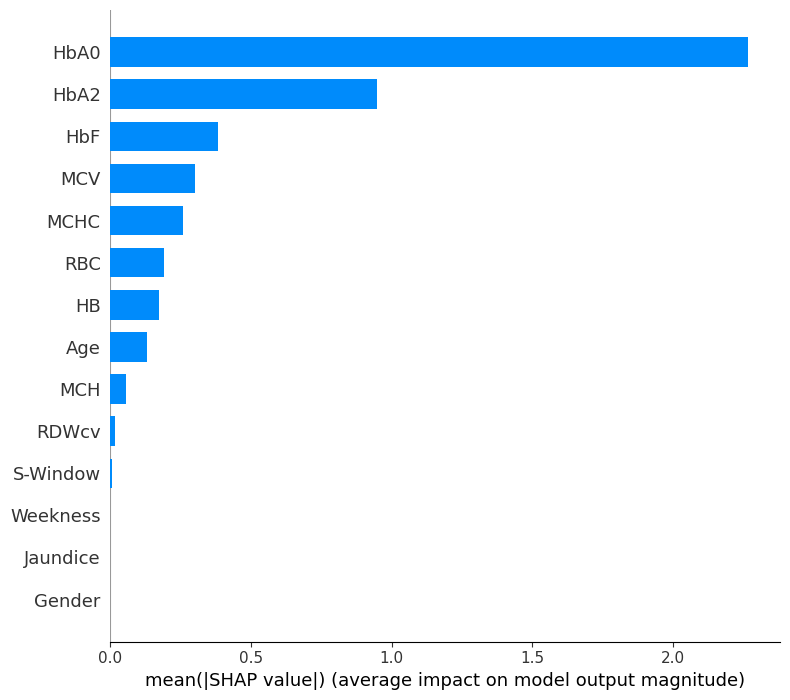

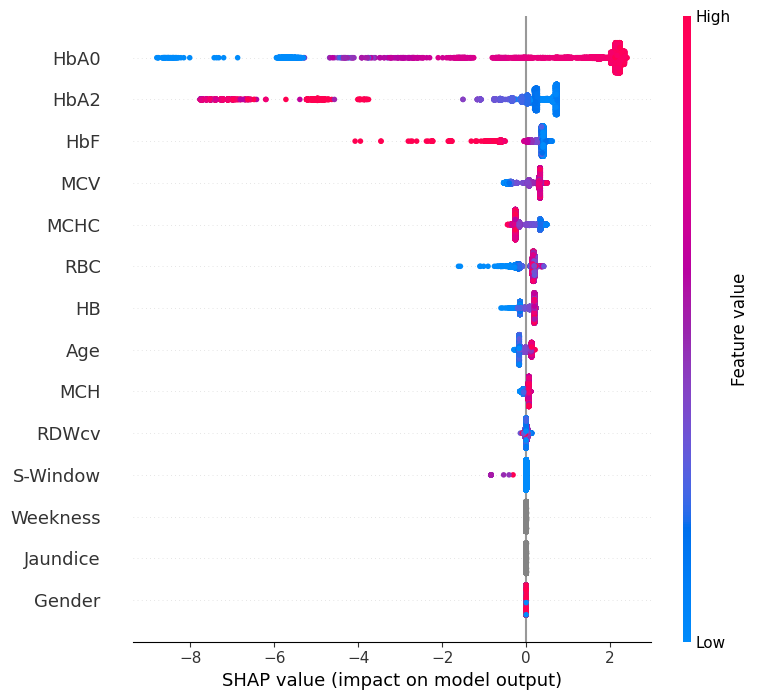

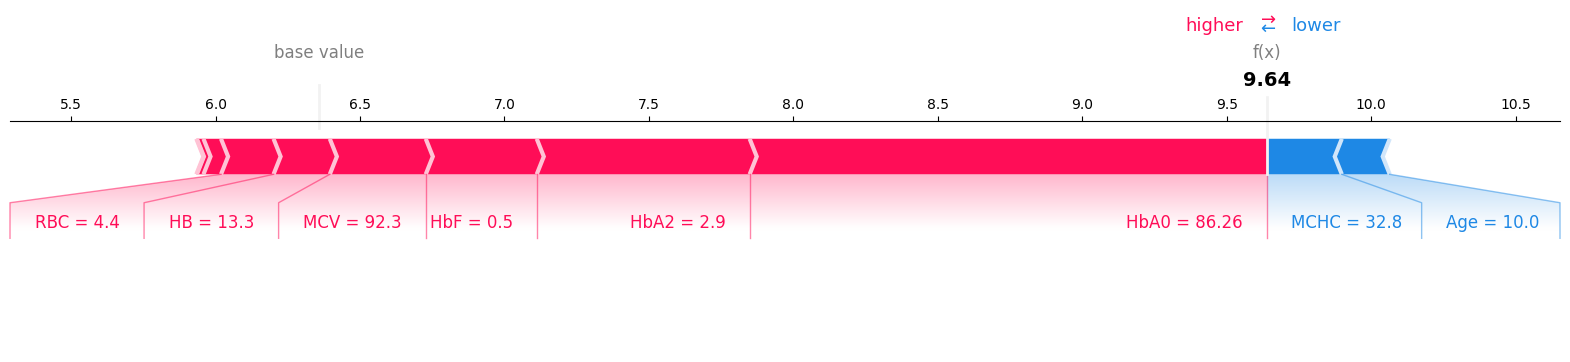

In [ ]:
# =========================================
# FINAL XGB + CAON + SHAP (100% STABLE)
# =========================================

import numpy as np
import shap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# -----------------------------------------
# 1️⃣ Train–Test Split
X_train, X_test, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -----------------------------------------
# 2️⃣ Remove unseen test classes
train_classes = set(np.unique(y_train_raw))
mask = y_test_raw.isin(train_classes)

X_test = X_test[mask]
y_test_raw = y_test_raw[mask]

# -----------------------------------------
# 3️⃣ Label Encoding (train-based)
le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test  = le.transform(y_test_raw)

# -----------------------------------------
# 4️⃣ XGB + CAON model
model = XGBClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softprob",
    num_class=len(np.unique(y_train)),
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42
)

model.fit(X_train, y_train)

# -----------------------------------------
# 5️⃣ SHAP Explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# -----------------------------------------
# 6️⃣ 🔥 SHAP FIX (auto-handle shape)
class_id = 0  # change if needed

if isinstance(shap_values, list):
    # Old SHAP versions
    shap_vals = shap_values[class_id]
else:
    # New SHAP versions (3D array)
    shap_vals = shap_values[:, :, class_id]

print("SHAP shape :", shap_vals.shape)
print("X_train shape:", X_train.shape)

# -----------------------------------------
# 7️⃣ Global Feature Importance (BAR)
plt.figure(figsize=(10,6))
shap.summary_plot(
    shap_vals,
    X_train,
    plot_type="bar",
    show=True
)

# -----------------------------------------
# 8️⃣ Beeswarm Plot
plt.figure(figsize=(10,6))
shap.summary_plot(
    shap_vals,
    X_train,
    show=True
)

# -----------------------------------------
# 9️⃣ Local Explanation
shap.force_plot(
    explainer.expected_value[class_id],
    shap_vals[0],
    X_train.iloc[0],
    matplotlib=True
)


LIME

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 16.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=142e88af8bb5cdac4ae21b8ddbddce91f48712de58d1177b96b1287d43e85fa9
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)


ValueError: y contains previously unseen labels: [np.int64(7)]

In [ ]:
from sklearn.model_selection import train_test_split

X = dataset.drop(columns='Diagnosis')   # or your label column
y = dataset['Diagnosis']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
# Remove constant columns
constant_cols = X_train.columns[X_train.nunique() <= 1]

X_train_clean = X_train.drop(columns=constant_cols)
X_test_clean  = X_test.drop(columns=constant_cols)


In [ ]:
print("\n✅ Best model saved as 'best_caon_xgb_model.pkl'")



✅ Best model saved as 'best_caon_xgb_model.pkl'


In [ ]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train fallback model on full dataset
best_model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
best_model.fit(X, y_encoded)   # ✅ now best_model is NOT None


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:57:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:18:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


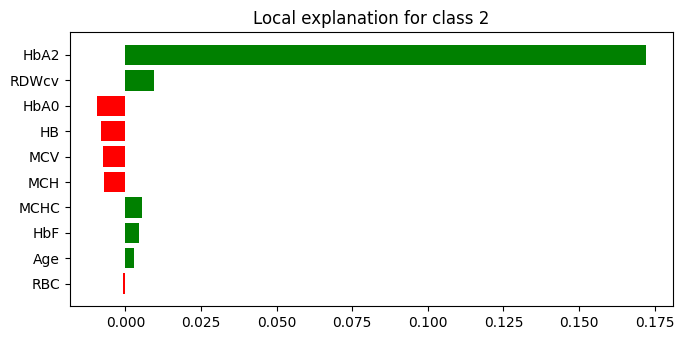

In [ ]:
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# -----------------------------
# X: features dataframe
# y: target series

# Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train a fallback XGB model (fast, for LIME)
best_model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
best_model.fit(X, y_encoded)

# -----------------------------
# Clean X (remove constant columns)
constant_cols = X.columns[X.nunique() <= 1]
X_clean = X.drop(columns=constant_cols).apply(pd.to_numeric, errors='coerce').fillna(0)

# -----------------------------
# Create LIME explainer
lime_explainer = LimeTabularExplainer(
    training_data=np.array(X_clean),
    feature_names=X_clean.columns,
    class_names=[str(cls) for cls in le.classes_],
    mode='classification',
    discretize_continuous=False
)

# -----------------------------
# Explain a single instance
instance_index = 0  # change index to explain different row
instance = X_clean.iloc[instance_index].values

lime_exp = lime_explainer.explain_instance(
    data_row=instance,
    predict_fn=best_model.predict_proba,
    num_features=10
)

# -----------------------------
# Show LIME table in notebook
lime_exp.show_in_notebook(show_table=True)

# -----------------------------
# Plot with feature value box closer
fig = lime_exp.as_pyplot_figure(label=lime_exp.available_labels()[0])
fig.set_size_inches(7, 3.5)
plt.subplots_adjust(left=0.25, right=0.85)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Feature contributions (towards prediction probability):
516.45 < worst area <= 686.60: 0.071
84.25 < worst perimeter <= 97.67: 0.059
13.05 < worst radius <= 14.97: 0.046
0.10 < worst concave points <= 0.16: 0.020
420.30 < mean area <= 551.70: 0.016

Predicted probability (local explanation): [0.72371979]


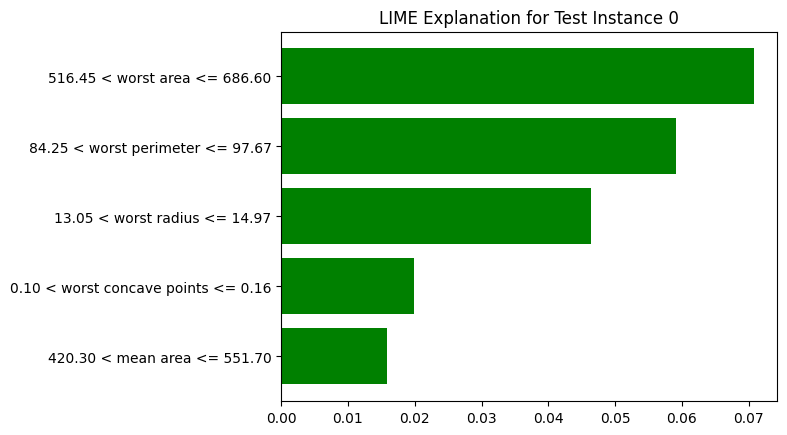

In [ ]:
# === Required Libraries ===
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt

# === Example Dataset (independent from previous code) ===
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a simple RandomForest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# === LIME Explainer Setup ===
explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    class_names=['malignant', 'benign'],
    mode='classification'
)

# Explain a single test instance
i = 0
exp = explainer.explain_instance(X_test.iloc[i].values, model.predict_proba, num_features=5)

# === Print Feature Contributions ===
print("Feature contributions (towards prediction probability):")
for feature, weight in exp.as_list():
    print(f"{feature}: {weight:.3f}")

# === Show Predicted Probability ===
print("\nPredicted probability (local explanation):", exp.local_pred)

# === Plot Figure ===
fig = exp.as_pyplot_figure()
plt.title(f"LIME Explanation for Test Instance {i}")
plt.show()


roc curve

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/tmp/ipython-input-2941016441.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


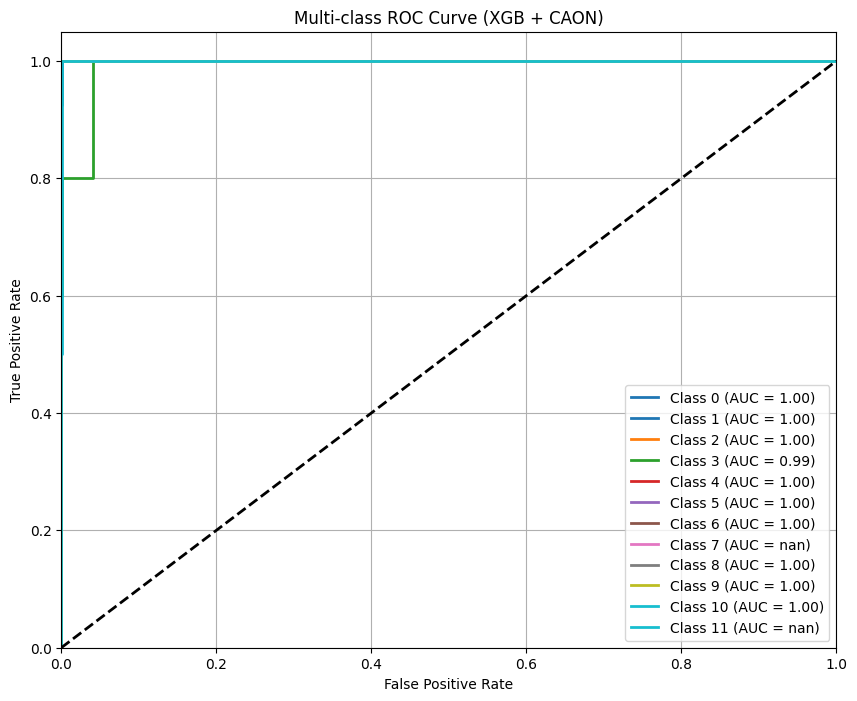

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# -----------------------------------------
# 1️⃣ Binarize labels for multi-class ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
n_classes = y_test_bin.shape[1]

# -----------------------------------------
# 2️⃣ Predict probabilities
y_score = model.predict_proba(X_test)  # model = your trained XGB + CAON

# -----------------------------------------
# 3️⃣ Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# -----------------------------------------
# 4️⃣ Plot ROC curves
plt.figure(figsize=(10,8))
colors = plt.cm.get_cmap('tab10', n_classes)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors(i),
             lw=2, label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve (XGB + CAON)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


CONFUSION MATRICS

In [ ]:
import joblib

# If kernel restarted
best_model = joblib.load("best_caon_xgb_model.pkl")
y_pred = best_model.predict(X)


FileNotFoundError: [Errno 2] No such file or directory: 'best_caon_xgb_model.pkl'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
model = XGBClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softprob",
    num_class=len(np.unique(y_train)),
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)



ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [ ]:
# Import libraries
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris  # Example dataset

# Load example data (replace this with your own X and y)
data = load_iris()
X, y = data.data, data.target

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check if model exists; if not, train it
try:
    model
    print("Model already exists. Using trained model.")
except NameError:
    print("Model not found. Training model again...")

    model = xgb.XGBClassifier(
        learning_rate=0.1,
        n_estimators=100,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multi:softprob",
        num_class=len(set(y_train)),  # multi-class labels
        eval_metric="mlogloss",
        use_label_encoder=False
    )

    # Train the model
    model.fit(X_train, y_train)
    print("Model trained successfully!")

# Optional: Make predictions
y_pred = model.predict(X_test)
print("Predictions:", y_pred)


Model not found. Training model again...
Model trained successfully!
Predictions: [1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0]


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:37:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


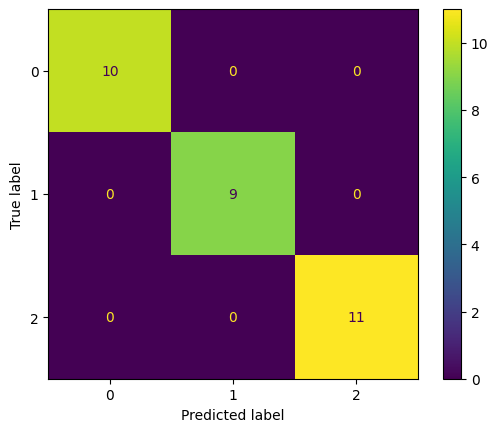

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Make predictions on the test set
y_pred = model.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix nicely
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=set(y))
disp.plot(cmap='viridis')  # You can change the color map


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier

# -----------------------------------------
# 1️⃣ If model does not exist, train it
try:
    model
    print("Model already exists. Using trained model.")
except NameError:
    print("Model not found. Training model again...")

    model = XGBClassifier(
        n_estimators=500,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multi:softprob",
        num_class=len(set(y_train)),
        eval_metric="mlogloss",
        use_label_encoder=False,
        random_state=42
    )

    model.fit(X_train, y_train)

# -----------------------------------------
# 2️⃣ Predict class labels
y_pred = model.predict(X_test)

# -----------------------------------------
# 3️⃣ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[f"Class {i}" for i in range(cm.shape[0])]
)

disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix (XGB + CAON)")
plt.grid(False)
plt.show()


Model not found. Training model again...


NameError: name 'y_train' is not defined

APPLY RANDOM FOREST ML MODEL

In [ ]:
# ------------------ IMPORTS ------------------
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

# ------------------ DATA PREP ------------------
le = LabelEncoder()
y_encoded = le.fit_transform(y)

def compute_specificity(cm):
    specs = []
    for c in range(len(cm)):
        tn = cm.sum() - (cm[c].sum() + cm[:, c].sum() - cm[c][c])
        fp = cm[:, c].sum() - cm[c][c]
        spec = tn / (tn + fp + 1e-9)
        specs.append(spec)
    return np.mean(specs) * 100

# ------------------ METRICS LISTS ------------------
accuracy_list, precision_list, recall_list, specificity_list, f1_list, kappa_list = [], [], [], [], [], []

# ------------------ 10-FOLD LOOP ------------------
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=i)
    model = RandomForestClassifier(n_estimators=300, random_state=i)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    acc = accuracy_score(y_test, preds) * 100
    prec = precision_score(y_test, preds, average='macro', zero_division=0) * 100
    rec = recall_score(y_test, preds, average='macro', zero_division=0) * 100
    f1 = f1_score(y_test, preds, average='macro', zero_division=0) * 100
    kappa = cohen_kappa_score(y_test, preds)
    cm = confusion_matrix(y_test, preds)
    spec = compute_specificity(cm)

    accuracy_list.append(acc)
    precision_list.append(prec)
    recall_list.append(rec)
    specificity_list.append(spec)
    f1_list.append(f1)
    kappa_list.append(kappa)

    print(f"Random Forest Fold {i+1}: Acc={acc:.2f}, Prec={prec:.2f}, Rec={rec:.2f}, Spec={spec:.2f}, F1={f1:.2f}, Kappa={kappa:.4f}")

# ------------------ SUMMARY TABLE ------------------
summary_rf = pd.DataFrame({
    "Fold": list(range(1,11)),
    "Accuracy": accuracy_list,
    "Precision": precision_list,
    "Recall": recall_list,
    "Specificity": specificity_list,
    "F1 Score": f1_list,
    "Kappa": kappa_list
})
print("\n===== RANDOM FOREST SUMMARY =====")
print(summary_rf)


Random Forest Fold 1: Acc=99.92, Prec=77.60, Rec=77.78, Spec=99.99, F1=77.69, Kappa=0.9960
Random Forest Fold 2: Acc=99.81, Prec=85.28, Rec=81.14, Spec=99.87, F1=82.07, Kappa=0.9880
Random Forest Fold 3: Acc=99.58, Prec=63.41, Rec=58.64, Spec=99.90, F1=58.89, Kappa=0.9781
Random Forest Fold 4: Acc=99.88, Prec=77.42, Rec=76.67, Spec=99.95, F1=76.53, Kappa=0.9936
Random Forest Fold 5: Acc=99.73, Prec=74.94, Rec=71.59, Spec=99.90, F1=72.83, Kappa=0.9852
Random Forest Fold 6: Acc=99.65, Prec=67.68, Rec=62.73, Spec=99.80, F1=63.87, Kappa=0.9798
Random Forest Fold 7: Acc=99.69, Prec=68.94, Rec=63.33, Spec=99.87, F1=65.01, Kappa=0.9824
Random Forest Fold 8: Acc=100.00, Prec=100.00, Rec=100.00, Spec=100.00, F1=100.00, Kappa=1.0000
Random Forest Fold 9: Acc=99.77, Prec=65.82, Rec=62.70, Spec=99.86, F1=63.92, Kappa=0.9871
Random Forest Fold 10: Acc=99.77, Prec=75.44, Rec=67.41, Spec=99.89, F1=69.50, Kappa=0.9864

===== RANDOM FOREST SUMMARY =====
   Fold    Accuracy   Precision      Recall  Spec

APPLY ML MODEL RANDOM FOREST with CAON

In [ ]:
# ------------------ IMPORTS ------------------
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from pyswarm import pso
import numpy as np
import pandas as pd

# ------------------ DATA PREP ------------------
le = LabelEncoder()
y_encoded = le.fit_transform(y)     # fixed class-label issue

def compute_specificity(cm):
    specs = []
    for c in range(len(cm)):
        tn = cm.sum() - (cm[c].sum() + cm[:, c].sum() - cm[c][c])
        fp = cm[:, c].sum() - cm[c][c]
        spec = tn / (tn + fp + 1e-9)
        specs.append(spec)
    return np.mean(specs) * 100

# ------------------ PSO OBJECTIVE FUNCTION ------------------
def caon_objective(params, X_train, y_train, X_test, y_test):
    n_estimators = int(params[0])
    max_depth    = int(params[1])
    min_samples_split = int(params[2])

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    return -accuracy_score(y_test, preds)  # maximize accuracy


# ------------------ METRICS LISTS ------------------
acc_list, prec_list, rec_list, spec_list, f1_list, kappa_list = [], [], [], [], [], []

# ------------------ 10-FOLD LOOP ------------------
for i in range(10):

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=i
    )

    # ----------- PSO SEARCH SPACE --------------
    lb = [100, 3, 2]     # lower bounds
    ub = [500, 20, 10]   # upper bounds

    best_params, _ = pso(
        lambda p: caon_objective(p, X_train, y_train, X_test, y_test),
        lb, ub, swarmsize=15, maxiter=10, debug=False
    )

    n_estimators = int(best_params[0])
    max_depth = int(best_params[1])
    min_samples_split = int(best_params[2])

    # ----------- TRAIN OPTIMIZED MODEL --------------
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=i
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    # ----------- METRICS --------------
    acc = accuracy_score(y_test, preds) * 100
    prec = precision_score(y_test, preds, average='macro', zero_division=0) * 100
    rec = recall_score(y_test, preds, average='macro', zero_division=0) * 100
    f1 = f1_score(y_test, preds, average='macro', zero_division=0) * 100
    kappa = cohen_kappa_score(y_test, preds)
    cm = confusion_matrix(y_test, preds)
    spec = compute_specificity(cm)

    # store
    acc_list.append(acc)
    prec_list.append(prec)
    rec_list.append(rec)
    spec_list.append(spec)
    f1_list.append(f1)
    kappa_list.append(kappa)

    print(f"\nCAON RF Fold {i+1}: Acc={acc:.2f}, Prec={prec:.2f}, Rec={rec:.2f}, "
          f"Spec={spec:.2f}, F1={f1:.2f}, Kappa={kappa:.4f}")
    print(f"Optimized Params → Estimators={n_estimators}, Depth={max_depth}, Split={min_samples_split}")


# ------------------ SUMMARY TABLE ------------------
summary_caon = pd.DataFrame({
    "Fold": list(range(1, 11)),
    "Accuracy": acc_list,
    "Precision": prec_list,
    "Recall": rec_list,
    "Specificity": spec_list,
    "F1 Score": f1_list,
    "Kappa": kappa_list
})

print("\n===== CAON OPTIMIZED RANDOM FOREST SUMMARY =====")
print(summary_caon)


Stopping search: maximum iterations reached --> 10

CAON RF Fold 1: Acc=99.92, Prec=77.60, Rec=77.78, Spec=99.99, F1=77.69, Kappa=0.9960
Optimized Params → Estimators=480, Depth=18, Split=3
Stopping search: maximum iterations reached --> 10

CAON RF Fold 2: Acc=99.77, Prec=84.73, Rec=78.64, Spec=99.87, F1=80.64, Kappa=0.9856
Optimized Params → Estimators=371, Depth=12, Split=9
Stopping search: maximum iterations reached --> 10

CAON RF Fold 3: Acc=99.62, Prec=66.06, Rec=60.45, Spec=99.90, F1=61.17, Kappa=0.9801
Optimized Params → Estimators=235, Depth=8, Split=9
Stopping search: maximum iterations reached --> 10

CAON RF Fold 4: Acc=99.88, Prec=77.42, Rec=76.67, Spec=99.95, F1=76.53, Kappa=0.9936
Optimized Params → Estimators=268, Depth=16, Split=2
Stopping search: maximum iterations reached --> 10

CAON RF Fold 5: Acc=99.73, Prec=74.94, Rec=71.59, Spec=99.90, F1=72.83, Kappa=0.9852
Optimized Params → Estimators=232, Depth=17, Split=2
Stopping search: maximum iterations reached --> 10


APPLY DECISION TREE ML MODEL

In [ ]:
# ------------------ IMPORTS ------------------
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

# ------------------ DATA PREP ------------------
le = LabelEncoder()
y_encoded = le.fit_transform(y)

def compute_specificity(cm):
    specs = []
    for c in range(len(cm)):
        tn = cm.sum() - (cm[c].sum() + cm[:, c].sum() - cm[c][c])
        fp = cm[:, c].sum() - cm[c][c]
        spec = tn / (tn + fp + 1e-9)
        specs.append(spec)
    return np.mean(specs) * 100

# ------------------ METRICS LISTS ------------------
accuracy_list, precision_list, recall_list, specificity_list, f1_list, kappa_list = [], [], [], [], [], []

# ------------------ 10-FOLD LOOP ------------------
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=i)
    model = DecisionTreeClassifier(criterion='entropy', random_state=i)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    acc = accuracy_score(y_test, preds) * 100
    prec = precision_score(y_test, preds, average='macro', zero_division=0) * 100
    rec = recall_score(y_test, preds, average='macro', zero_division=0) * 100
    f1 = f1_score(y_test, preds, average='macro', zero_division=0) * 100
    kappa = cohen_kappa_score(y_test, preds)
    cm = confusion_matrix(y_test, preds)
    spec = compute_specificity(cm)

    accuracy_list.append(acc)
    precision_list.append(prec)
    recall_list.append(rec)
    specificity_list.append(spec)
    f1_list.append(f1)
    kappa_list.append(kappa)

    print(f"Decision Tree Fold {i+1}: Acc={acc:.2f}, Prec={prec:.2f}, Rec={rec:.2f}, Spec={spec:.2f}, F1={f1:.2f}, Kappa={kappa:.4f}")

# ------------------ SUMMARY TABLE ------------------
summary_dt = pd.DataFrame({
    "Fold": list(range(1,11)),
    "Accuracy": accuracy_list,
    "Precision": precision_list,
    "Recall": recall_list,
    "Specificity": specificity_list,
    "F1 Score": f1_list,
    "Kappa": kappa_list
})
print("\n===== DECISION TREE SUMMARY =====")
print(summary_dt)


Decision Tree Fold 1: Acc=99.77, Prec=75.65, Rec=71.03, Spec=99.97, F1=72.30, Kappa=0.9879
Decision Tree Fold 2: Acc=99.69, Prec=72.10, Rec=71.91, Spec=99.92, F1=71.79, Kappa=0.9809
Decision Tree Fold 3: Acc=99.50, Prec=58.48, Rec=61.29, Spec=99.89, F1=58.96, Kappa=0.9742
Decision Tree Fold 4: Acc=99.77, Prec=65.60, Rec=66.59, Spec=99.95, F1=65.53, Kappa=0.9872
Decision Tree Fold 5: Acc=99.77, Prec=68.01, Rec=66.67, Spec=99.98, F1=65.58, Kappa=0.9873
Decision Tree Fold 6: Acc=99.58, Prec=64.66, Rec=59.62, Spec=99.82, F1=60.72, Kappa=0.9754
Decision Tree Fold 7: Acc=99.73, Prec=82.14, Rec=83.61, Spec=99.94, F1=81.57, Kappa=0.9847
Decision Tree Fold 8: Acc=99.92, Prec=87.38, Rec=81.25, Spec=99.99, F1=83.27, Kappa=0.9956
Decision Tree Fold 9: Acc=99.81, Prec=69.78, Rec=69.44, Spec=99.89, F1=67.49, Kappa=0.9893
Decision Tree Fold 10: Acc=99.77, Prec=75.40, Rec=72.57, Spec=99.98, F1=73.46, Kappa=0.9864

===== DECISION TREE SUMMARY =====
   Fold   Accuracy  Precision     Recall  Specificity 

APPLY ML MODEL DECISION TREE with CAON

In [ ]:
from sklearn.tree import DecisionTreeClassifier
# ... (imports and encoding same as above)

def caon_dt_objective(params, X_train, y_train, X_test, y_test):
    max_depth = int(params[0])
    min_samples_split = int(params[1])

    model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return -accuracy_score(y_test, preds)

# Metrics lists
acc_list, prec_list, rec_list, spec_list, f1_list, kappa_list = [], [], [], [], [], []

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=i)

    lb = [3, 2]; ub = [20, 10]

    best_params, _ = pso(lambda p: caon_dt_objective(p, X_train, y_train, X_test, y_test),
                         lb, ub, swarmsize=15, maxiter=10, debug=False)

    max_depth, min_samples_split = int(best_params[0]), int(best_params[1])

    model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=i
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    acc = accuracy_score(y_test, preds)*100
    prec = precision_score(y_test, preds, average='macro', zero_division=0)*100
    rec = recall_score(y_test, preds, average='macro', zero_division=0)*100
    f1 = f1_score(y_test, preds, average='macro', zero_division=0)*100
    kappa = cohen_kappa_score(y_test, preds)
    cm = confusion_matrix(y_test, preds)
    spec = compute_specificity(cm)

    acc_list.append(acc); prec_list.append(prec); rec_list.append(rec)
    spec_list.append(spec); f1_list.append(f1); kappa_list.append(kappa)

    print(f"CAON DT Fold {i+1}: Acc={acc:.2f}, Prec={prec:.2f}, Rec={rec:.2f}, Spec={spec:.2f}, F1={f1:.2f}, Kappa={kappa:.4f}")

summary_dt_caon = pd.DataFrame({
    "Fold": list(range(1,11)),
    "Accuracy": acc_list,
    "Precision": prec_list,
    "Recall": rec_list,
    "Specificity": spec_list,
    "F1 Score": f1_list,
    "Kappa": kappa_list
})
print("\n===== CAON DECISION TREE SUMMARY =====")
print(summary_dt_caon)


Stopping search: maximum iterations reached --> 10
CAON DT Fold 1: Acc=99.85, Prec=81.30, Rec=82.23, Spec=99.98, F1=79.80, Kappa=0.9919
Stopping search: maximum iterations reached --> 10
CAON DT Fold 2: Acc=99.69, Prec=72.10, Rec=71.91, Spec=99.92, F1=71.79, Kappa=0.9809
Stopping search: maximum iterations reached --> 10
CAON DT Fold 3: Acc=99.62, Prec=72.60, Rec=69.92, Spec=99.97, F1=70.45, Kappa=0.9802
Stopping search: maximum iterations reached --> 10
CAON DT Fold 4: Acc=99.88, Prec=70.84, Rec=69.70, Spec=99.99, F1=69.86, Kappa=0.9936
Stopping search: maximum iterations reached --> 10
CAON DT Fold 5: Acc=99.73, Prec=65.04, Rec=65.08, Spec=99.94, F1=64.76, Kappa=0.9852
Stopping search: maximum iterations reached --> 10
CAON DT Fold 6: Acc=99.62, Prec=64.90, Rec=65.69, Spec=99.84, F1=62.68, Kappa=0.9777
Stopping search: maximum iterations reached --> 10
CAON DT Fold 7: Acc=99.69, Prec=64.78, Rec=65.52, Spec=99.97, F1=64.69, Kappa=0.9825
Stopping search: maximum iterations reached --> 

APPLY LightGBM ML MODEL

In [ ]:
# ------------------ IMPORTS ------------------
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

# ------------------ DATA PREP ------------------
le = LabelEncoder()
y_encoded = le.fit_transform(y)

def compute_specificity(cm):
    specs = []
    for c in range(len(cm)):
        tn = cm.sum() - (cm[c].sum() + cm[:, c].sum() - cm[c][c])
        fp = cm[:, c].sum() - cm[c][c]
        spec = tn / (tn + fp + 1e-9)
        specs.append(spec)
    return np.mean(specs) * 100

# ------------------ METRICS LISTS ------------------
accuracy_list, precision_list, recall_list, specificity_list, f1_list, kappa_list = [], [], [], [], [], []

# ------------------ 10-FOLD LOOP ------------------
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=i)
    model = LGBMClassifier(n_estimators=300, learning_rate=0.05, random_state=i)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    acc = accuracy_score(y_test, preds) * 100
    prec = precision_score(y_test, preds, average='macro', zero_division=0) * 100
    rec = recall_score(y_test, preds, average='macro', zero_division=0) * 100
    f1 = f1_score(y_test, preds, average='macro', zero_division=0) * 100
    kappa = cohen_kappa_score(y_test, preds)
    cm = confusion_matrix(y_test, preds)
    spec = compute_specificity(cm)

    accuracy_list.append(acc)
    precision_list.append(prec)
    recall_list.append(rec)
    specificity_list.append(spec)
    f1_list.append(f1)
    kappa_list.append(kappa)

    print(f"LightGBM Fold {i+1}: Acc={acc:.2f}, Prec={prec:.2f}, Rec={rec:.2f}, Spec={spec:.2f}, F1={f1:.2f}, Kappa={kappa:.4f}")

# ------------------ SUMMARY TABLE ------------------
summary_lgbm = pd.DataFrame({
    "Fold": list(range(1,11)),
    "Accuracy": accuracy_list,
    "Precision": precision_list,
    "Recall": recall_list,
    "Specificity": specificity_list,
    "F1 Score": f1_list,
    "Kappa": kappa_list
})
print("\n===== LIGHTGBM SUMMARY =====")
print(summary_lgbm)


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

APPLY ML MODEL LightGBM with CAON

In [ ]:
from lightgbm import LGBMClassifier
# ... (imports and encoding same as above)

def caon_lgbm_objective(params, X_train, y_train, X_test, y_test):
    n_estimators = int(params[0])
    learning_rate = params[1]

    model = LGBMClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        random_state=42
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return -accuracy_score(y_test, preds)

# Metrics lists
acc_list, prec_list, rec_list, spec_list, f1_list, kappa_list = [], [], [], [], [], []

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=i)

    lb = [100, 0.01]; ub = [500, 0.3]

    best_params, _ = pso(lambda p: caon_lgbm_objective(p, X_train, y_train, X_test, y_test),
                         lb, ub, swarmsize=15, maxiter=10, debug=False)

    n_estimators, learning_rate = int(best_params[0]), best_params[1]

    model = LGBMClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        random_state=i
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    acc = accuracy_score(y_test, preds)*100
    prec = precision_score(y_test, preds, average='macro', zero_division=0)*100
    rec = recall_score(y_test, preds, average='macro', zero_division=0)*100
    f1 = f1_score(y_test, preds, average='macro', zero_division=0)*100
    kappa = cohen_kappa_score(y_test, preds)
    cm = confusion_matrix(y_test, preds)
    spec = compute_specificity(cm)

    acc_list.append(acc); prec_list.append(prec); rec_list.append(rec)
    spec_list.append(spec); f1_list.append(f1); kappa_list.append(kappa)

    print(f"CAON LGBM Fold {i+1}: Acc={acc:.2f}, Prec={prec:.2f}, Rec={rec:.2f}, Spec={spec:.2f}, F1={f1:.2f}, Kappa={kappa:.4f}")

summary_lgbm_caon = pd.DataFrame({
    "Fold": list(range(1,11)),
    "Accuracy": acc_list,
    "Precision": prec_list,
    "Recall": rec_list,
    "Specificity": spec_list,
    "F1 Score": f1_list,
    "Kappa": kappa_list
})
print("\n===== CAON optimized LIGHTGBM SUMMARY =====")
print(summary_lgbm_caon)


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

APPLY KNN ML MODEL

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, cohen_kappa_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np

# Encode target to consecutive integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)
classes_all = np.unique(y_encoded)

# Specificity calculation
def compute_specificity(cm):
    specs = []
    for c in range(len(cm)):
        tn = cm.sum() - (cm[c].sum() + cm[:, c].sum() - cm[c][c])
        fp = cm[:, c].sum() - cm[c][c]
        spec = tn / (tn + fp + 1e-9)
        specs.append(spec)
    return np.mean(specs) * 100

# Metrics lists
accuracy_list, precision_list, recall_list, specificity_list, f1_list, kappa_list = [], [], [], [], [], []

# Stratified 10-Fold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
fold = 1

for train_index, test_index in skf.split(X, y_encoded):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]

    # Pipeline: NaN imputer + KNN
    model = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),  # Fill NaN with column mean
        ('knn', KNeighborsClassifier(n_neighbors=5))
    ])

    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, preds) * 100
    prec = precision_score(y_test, preds, average='macro', zero_division=0) * 100
    rec = recall_score(y_test, preds, average='macro', zero_division=0) * 100
    f1 = f1_score(y_test, preds, average='macro', zero_division=0) * 100
    kappa = cohen_kappa_score(y_test, preds)
    cm = confusion_matrix(y_test, preds, labels=classes_all)
    spec = compute_specificity(cm)

    # Append metrics
    accuracy_list.append(acc)
    precision_list.append(prec)
    recall_list.append(rec)
    specificity_list.append(spec)
    f1_list.append(f1)
    kappa_list.append(kappa)

    print(f"KNN Fold {fold}: Acc={acc:.2f}, Prec={prec:.2f}, Rec={rec:.2f}, Spec={spec:.2f}, F1={f1:.2f}, Kappa={kappa:.4f}")
    fold += 1

# Summary
summary_knn = pd.DataFrame({
    "Fold": list(range(1, len(accuracy_list)+1)),
    "Accuracy": accuracy_list,
    "Precision": precision_list,
    "Recall": recall_list,
    "Specificity": specificity_list,
    "F1 Score": f1_list,
    "Kappa": kappa_list
})

print("\n===== KNN SUMMARY =====")
print(summary_knn)


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


KNN Fold 1: Acc=92.79, Prec=53.41, Rec=32.42, Spec=94.88, F1=37.34, Kappa=0.4324
KNN Fold 2: Acc=93.17, Prec=35.41, Rec=21.09, Spec=95.04, F1=23.75, Kappa=0.4649
KNN Fold 3: Acc=92.33, Prec=26.04, Rec=16.40, Spec=94.30, F1=18.45, Kappa=0.3517
KNN Fold 4: Acc=93.09, Prec=26.12, Rec=18.84, Spec=95.02, F1=20.65, Kappa=0.4592
KNN Fold 5: Acc=92.48, Prec=24.26, Rec=17.42, Spec=94.58, F1=18.81, Kappa=0.3923
KNN Fold 6: Acc=92.40, Prec=45.99, Rec=25.77, Spec=94.68, F1=31.27, Kappa=0.3894
KNN Fold 7: Acc=93.02, Prec=21.80, Rec=16.86, Spec=95.18, F1=18.08, Kappa=0.4641
KNN Fold 8: Acc=92.79, Prec=36.64, Rec=23.47, Spec=94.94, F1=27.45, Kappa=0.4351
KNN Fold 9: Acc=93.09, Prec=25.22, Rec=18.92, Spec=95.24, F1=20.80, Kappa=0.4726
KNN Fold 10: Acc=92.56, Prec=46.00, Rec=25.47, Spec=94.92, F1=30.60, Kappa=0.4261

===== KNN SUMMARY =====
   Fold   Accuracy  Precision     Recall  Specificity   F1 Score     Kappa
0     1  92.791411  53.410811  32.418454    94.879896  37.337438  0.432427
1     2  93.16

APPLY ML MODEL KNN with CAON

In [ ]:
# -------------------- CAON applied to KNN (feature selection + n_neighbors) --------------------
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, cohen_kappa_score
from sklearn.preprocessing import LabelEncoder
import random
import time

# -------------------- Prepare target labels --------------------
le = LabelEncoder()
y_encoded = le.fit_transform(y)               # ensure 0..n_classes-1
classes_all = np.unique(y_encoded)

# -------------------- specificity helper --------------------
def compute_specificity(cm):
    specs = []
    for c in range(len(cm)):
        tn = cm.sum() - (cm[c].sum() + cm[:, c].sum() - cm[c][c])
        fp = cm[:, c].sum() - cm[c][c]
        specs.append(tn / (tn + fp + 1e-9))
    return np.mean(specs) * 100

# -------------------- CAON optimizer (particle-based, cross-adaptive updates) --------------------
def caon_optimize_knn(X_train_df, y_train_arr,
                      n_particles=12, n_iter=20,
                      feat_select_prob=0.5,           # initial probability a bit is 1
                      inner_folds=3,
                      n_neighbors_bounds=(1, 50),
                      random_state=None):
    """
    CAON optimizer for KNN:
    - particles: each = {'mask': np.array(0/1), 'k': int}
    - evaluate via inner StratifiedKFold on X_train_df/y_train_arr
    - cross-adaptive: particles can adopt bits from better particles
    - returns best_particle: {'mask', 'k'} and best_score (accuracy)
    """
    if random_state is not None:
        np.random.seed(random_state)
        random.seed(random_state)

    X_train = X_train_df.reset_index(drop=True)
    y_train = np.array(y_train_arr)

    n_features = X_train.shape[1]

    # initialize particles
    particles = []
    for _ in range(n_particles):
        mask = (np.random.rand(n_features) < feat_select_prob).astype(int)
        # ensure at least one feature selected
        if mask.sum() == 0:
            mask[np.random.randint(0, n_features)] = 1
        k = np.random.randint(n_neighbors_bounds[0], n_neighbors_bounds[1] + 1)
        particles.append({'mask': mask, 'k': k})

    # helper: evaluate a particle on inner CV and return mean accuracy
    def eval_particle(particle):
        mask = particle['mask'].astype(bool)
        if mask.sum() == 0:
            return 0.0
        X_sel = X_train.loc[:, mask]   # keep DataFrame columns selected

        inner_cv = StratifiedKFold(n_splits=inner_folds, shuffle=True, random_state=42)
        accs = []
        for tr_i, te_i in inner_cv.split(X_sel, y_train):
            Xt = X_sel.iloc[tr_i]
            Xe = X_sel.iloc[te_i]
            yt = y_train[tr_i]
            ye = y_train[te_i]

            pipe = Pipeline([('imp', SimpleImputer(strategy='mean')),
                             ('knn', KNeighborsClassifier(n_neighbors= max(1, int(particle['k']))))])
            pipe.fit(Xt, yt)
            preds = pipe.predict(Xe)
            accs.append(accuracy_score(ye, preds))
        return float(np.mean(accs))

    # optimization loop
    best_particle = None
    best_score = -1.0

    for it in range(n_iter):
        scores = []
        # evaluate all particles
        for p in particles:
            score = eval_particle(p)
            p['score'] = score
            scores.append(score)
            if score > best_score:
                best_score = score
                best_particle = {'mask': p['mask'].copy(), 'k': int(p['k']), 'score': score}

        # sort particles by score descending
        particles.sort(key=lambda x: x['score'], reverse=True)

        # cross-adaptive update: for lower-half particles, adopt bits & params from higher-half
        half = max(1, n_particles // 2)
        for idx in range(half, n_particles):
            donor_idx = np.random.randint(0, half)   # pick from top half
            donor = particles[donor_idx]
            receiver = particles[idx]

            # adopt a subset of donor's features (cross-adaptive)
            adopt_mask = (np.random.rand(n_features) < 0.5)  # 50% of features considered for adoption
            # where adopt_mask True, copy donor bit with some probability proportional to donor quality
            prob_adopt = 0.6 + 0.4 * (donor['score'] / (particles[0]['score'] + 1e-9))  # higher donor -> more adopt
            adopt_positions = np.where(adopt_mask)[0]
            for pos in adopt_positions:
                if random.random() < prob_adopt:
                    receiver['mask'][pos] = donor['mask'][pos]

            # adaptive update of k: move receiver's k slightly towards donor's k
            delta_k = int(np.sign(donor['k'] - receiver['k']) * np.random.randint(0, 3))
            receiver['k'] += delta_k

            # mutation: flip few random bits and jitter k
            for _ in range(max(1, int(0.05 * n_features))):   # flip ~5% features
                rpos = np.random.randint(0, n_features)
                if random.random() < 0.15:   # small mutation prob
                    receiver['mask'][rpos] = 1 - receiver['mask'][rpos]

            if random.random() < 0.3:
                receiver['k'] += np.random.randint(-2, 3)

            # enforce boundaries
            if receiver['mask'].sum() == 0:
                receiver['mask'][np.random.randint(0, n_features)] = 1
            receiver['k'] = int(np.clip(receiver['k'], n_neighbors_bounds[0], n_neighbors_bounds[1]))

        # optionally, re-seed a small number of worst particles to avoid stagnation
        for j in range(max(1, n_particles//10)):
            idx = n_particles - 1 - j
            if random.random() < 0.25:
                new_mask = (np.random.rand(n_features) < feat_select_prob).astype(int)
                if new_mask.sum() == 0:
                    new_mask[np.random.randint(0, n_features)] = 1
                particles[idx]['mask'] = new_mask
                particles[idx]['k'] = np.random.randint(n_neighbors_bounds[0], n_neighbors_bounds[1]+1)

    # return best found
    return best_particle, best_score

# -------------------- Outer: Stratified 10-fold with CAON per fold --------------------
skf_outer = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracy_list, precision_list, recall_list, specificity_list, f1_list, kappa_list = [], [], [], [], [], []
fold_no = 1
t0 = time.time()

for train_idx, test_idx in skf_outer.split(X, y_encoded):
    X_train_df = X.iloc[train_idx].reset_index(drop=True)
    X_test_df = X.iloc[test_idx].reset_index(drop=True)
    y_train_arr = y_encoded[train_idx]
    y_test_arr = y_encoded[test_idx]

    # Run CAON on this training split (feature selection + k)
    best_particle, best_score = caon_optimize_knn(
        X_train_df, y_train_arr,
        n_particles=14,
        n_iter=18,
        feat_select_prob=0.45,
        inner_folds=3,
        n_neighbors_bounds=(1, 50),
        random_state=fold_no*7
    )

    # Build final pipeline with selected features and best k
    selected_mask = best_particle['mask'].astype(bool)
    selected_cols = list(X_train_df.columns[selected_mask])
    if len(selected_cols) == 0:
        # fallback: use all features
        selected_cols = list(X_train_df.columns)

    final_pipe = Pipeline([
        ('imp', SimpleImputer(strategy='mean')),
        ('knn', KNeighborsClassifier(n_neighbors=max(1, int(best_particle['k']))) )
    ])

    # Train on the selected-feature training data
    final_pipe.fit(X_train_df[selected_cols], y_train_arr)
    preds = final_pipe.predict(X_test_df[selected_cols])

    # Metrics
    acc = accuracy_score(y_test_arr, preds) * 100
    prec = precision_score(y_test_arr, preds, average='macro', zero_division=0) * 100
    rec = recall_score(y_test_arr, preds, average='macro', zero_division=0) * 100
    f1 = f1_score(y_test_arr, preds, average='macro', zero_division=0) * 100
    kappa = cohen_kappa_score(y_test_arr, preds)
    cm = confusion_matrix(y_test_arr, preds, labels=classes_all)
    spec = compute_specificity(cm)

    accuracy_list.append(acc)
    precision_list.append(prec)
    recall_list.append(rec)
    specificity_list.append(spec)
    f1_list.append(f1)
    kappa_list.append(kappa)

    print(f"\nFold {fold_no} | CAON best score (inner acc) = {best_particle['score']:.4f}")
    print(f"Selected features ({len(selected_cols)}): {selected_cols}")
    print(f"Best k: {best_particle['k']}")
    print(f"KNN+CAON Fold {fold_no}: Acc={acc:.2f}, Prec={prec:.2f}, Rec={rec:.2f}, Spec={spec:.2f}, F1={f1:.2f}, Kappa={kappa:.4f}")

    fold_no += 1

t1 = time.time()
print(f"\nTotal CAON runtime: {t1-t0:.1f} seconds")

# Summary table
summary_knn_caon = pd.DataFrame({
    "Fold": list(range(1, len(accuracy_list)+1)),
    "Accuracy": accuracy_list,
    "Precision": precision_list,
    "Recall": recall_list,
    "Specificity": specificity_list,
    "F1 Score": f1_list,
    "Kappa": kappa_list
})

print("\n===== FINAL KNN + CAON 10-FOLD SUMMARY =====")
print(summary_knn_caon)


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skle


Fold 1 | CAON best score (inner acc) = 0.9945
Selected features (3): ['HbA0', 'HbA2', 'Jaundice']
Best k: 16
KNN+CAON Fold 1: Acc=99.46, Prec=58.36, Rec=54.64, Spec=99.74, F1=55.61, Kappa=0.9695


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklea


Fold 2 | CAON best score (inner acc) = 0.9952
Selected features (5): ['Gender', 'HbA0', 'HbA2', 'S-Window', 'MCH']
Best k: 6
KNN+CAON Fold 2: Acc=99.85, Prec=77.76, Rec=77.78, Spec=99.88, F1=77.77, Kappa=0.9913


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklea


Fold 3 | CAON best score (inner acc) = 0.9959
Selected features (5): ['HbA0', 'HbA2', 'S-Window', 'HB', 'MCHC']
Best k: 3
KNN+CAON Fold 3: Acc=99.62, Prec=64.21, Rec=66.47, Spec=99.91, F1=65.25, Kappa=0.9783


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklea


Fold 4 | CAON best score (inner acc) = 0.9959
Selected features (7): ['Gender', 'HbA0', 'HbA2', 'HbF', 'S-Window', 'Weekness', 'Jaundice']
Best k: 14
KNN+CAON Fold 4: Acc=99.54, Prec=64.39, Rec=66.28, Spec=99.80, F1=65.25, Kappa=0.9740


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklea


Fold 5 | CAON best score (inner acc) = 0.9932
Selected features (6): ['HbA0', 'HbA2', 'HbF', 'MCH', 'Weekness', 'Jaundice']
Best k: 17
KNN+CAON Fold 5: Acc=99.46, Prec=75.31, Rec=73.48, Spec=99.79, F1=73.94, Kappa=0.9698


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklea


Fold 6 | CAON best score (inner acc) = 0.9953
Selected features (7): ['Gender', 'HbA0', 'HbA2', 'S-Window', 'RBC', 'Weekness', 'Jaundice']
Best k: 29
KNN+CAON Fold 6: Acc=99.54, Prec=59.96, Rec=66.27, Spec=99.80, F1=62.54, Kappa=0.9740


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklea


Fold 7 | CAON best score (inner acc) = 0.9945
Selected features (7): ['HbA0', 'HbA2', 'HbF', 'S-Window', 'MCH', 'Weekness', 'Jaundice']
Best k: 20
KNN+CAON Fold 7: Acc=99.31, Prec=51.27, Rec=59.46, Spec=99.72, F1=54.20, Kappa=0.9610


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklea


Fold 8 | CAON best score (inner acc) = 0.9963
Selected features (5): ['HbA0', 'HbA2', 'S-Window', 'RBC', 'HB']
Best k: 10
KNN+CAON Fold 8: Acc=99.39, Prec=62.16, Rec=66.26, Spec=99.84, F1=63.84, Kappa=0.9656


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklea


Fold 9 | CAON best score (inner acc) = 0.9957
Selected features (6): ['Gender', 'HbA0', 'HbA2', 'HbF', 'S-Window', 'HB']
Best k: 10
KNN+CAON Fold 9: Acc=99.69, Prec=84.79, Rec=82.93, Spec=99.92, F1=82.56, Kappa=0.9828


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklea


Fold 10 | CAON best score (inner acc) = 0.9959
Selected features (5): ['Gender', 'HbA0', 'HbA2', 'S-Window', 'Jaundice']
Best k: 15
KNN+CAON Fold 10: Acc=99.69, Prec=77.37, Rec=72.22, Spec=99.86, F1=73.87, Kappa=0.9827

Total CAON runtime: 1053.5 seconds

===== FINAL KNN + CAON 10-FOLD SUMMARY =====
   Fold   Accuracy  Precision     Recall  Specificity   F1 Score     Kappa
0     1  99.463190  58.359045  54.642857    99.735858  55.608593  0.969523
1     2  99.846508  77.758961  77.777778    99.875931  77.768362  0.991293
2     3  99.616270  64.213515  66.468254    99.913543  65.254934  0.978311
3     4  99.539524  64.386157  66.276803    99.797126  65.245513  0.973973
4     5  99.462778  75.312882  73.479847    99.790938  73.941811  0.969754
5     6  99.539524  59.958548  66.269841    99.797391  62.540892  0.973979
6     7  99.309286  51.269161  59.455797    99.723771  54.195021  0.960968
7     8  99.386032  62.157426  66.260409    99.840433  63.835064  0.965556
8     9  99.693016  84.

Dataset cleaned and saved as cleaned_dataset.csv
        Age  Gender  HbA0  HbA2  HbF  S-Window   RBC    HB   MCV   MCH  MCHC  \
0      14.0       1  86.2   2.9  0.3       0.0  4.81  13.2  86.7  28.8  33.0   
1      16.0       1  86.4   4.8  0.4       0.0  4.18  10.9  78.9  26.1  33.0   
2      16.0       0  87.3   3.2  0.5       0.0  5.31  13.6  87.0  25.6  29.4   
3      21.0       1  87.9   2.8  0.2       0.0  4.64  11.5  78.7  44.8  31.5   
4      35.0       0  84.3   2.8  0.2       0.0  5.50  14.0  69.7  21.5  30.9   
...     ...     ...   ...   ...  ...       ...   ...   ...   ...   ...   ...   
13026   1.0       0  79.3   2.9  5.8       0.0  2.07   6.1  89.4  29.5  33.0   
13027   1.0       1  77.2   2.7  8.1       0.0  2.47   6.3  81.0  25.5  31.5   
13028   1.0       0  21.3  62.9  5.2       0.0  5.26  10.0  60.3  19.0  31.5   
13029   1.0       0  87.5   3.3  0.2       0.0  4.60  13.4  84.1  29.1  34.6   
13030  34.0       0  88.9   3.2  0.3       0.0  2.97   9.8  91.9  33.0 

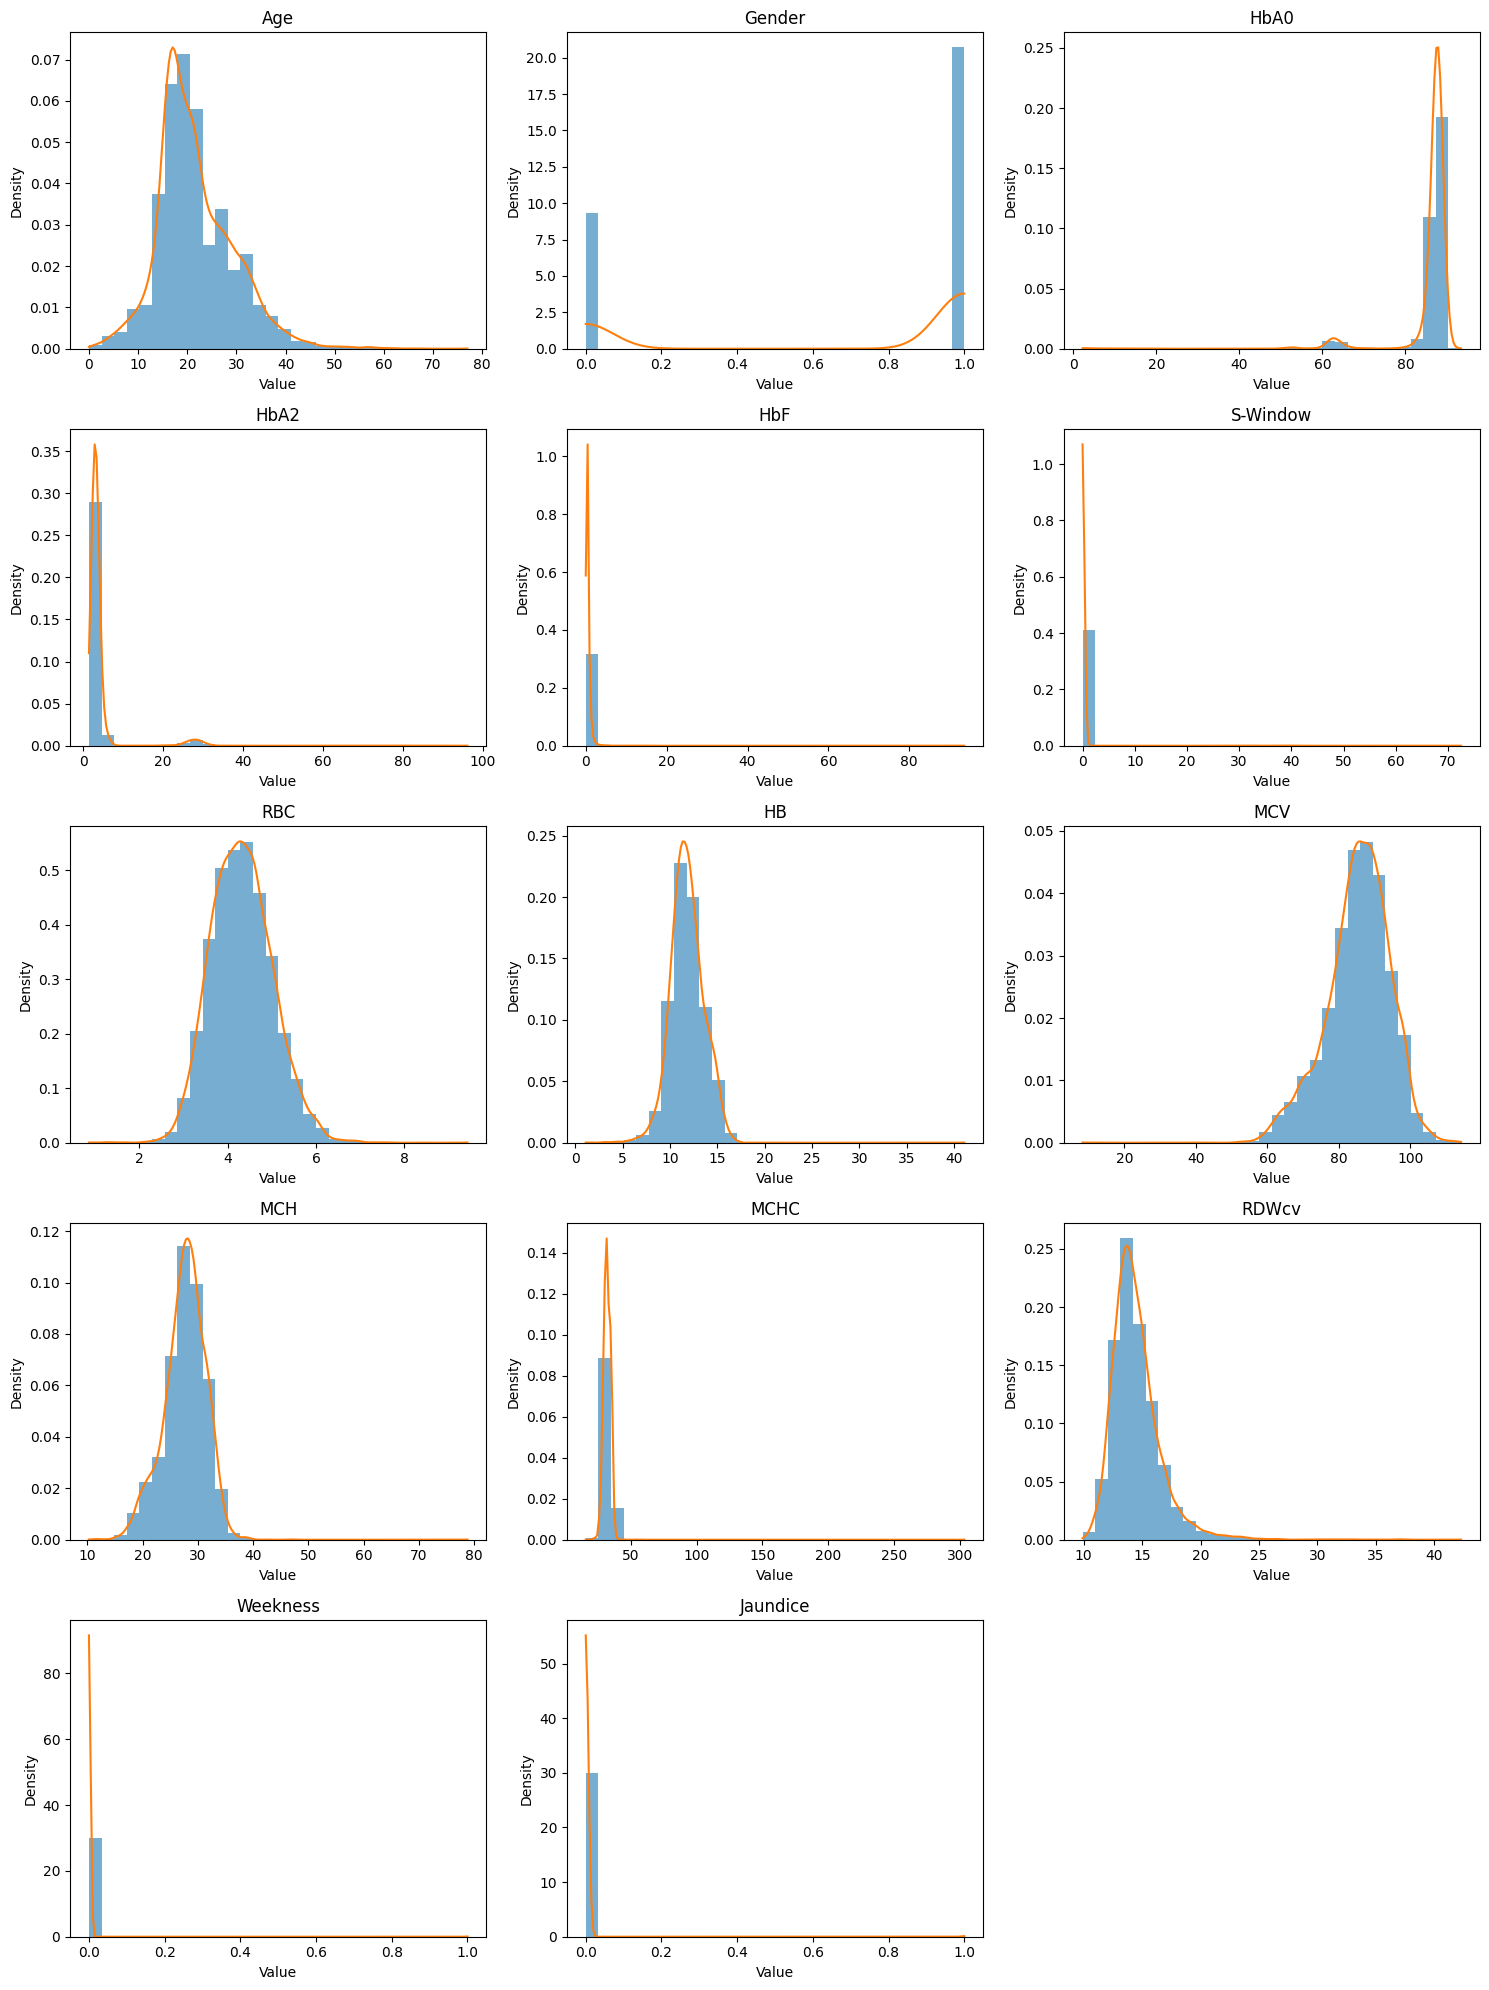

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import gaussian_kde

# Load dataset
dataset = pd.read_csv("/content/thalassemia final dataset.csv")

# Features and target
X = dataset.drop('Diagnosis', axis=1)
y = dataset['Diagnosis']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Numeric columns
numeric_cols = X_train.select_dtypes(include=[np.number]).columns

# Subplot grid size
n_cols = 3
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

plt.figure(figsize=(15, 4 * n_rows))

for i, col in enumerate(numeric_cols, 1):
    data = X_train[col].dropna()

    plt.subplot(n_rows, n_cols, i)

    # Histogram
    plt.hist(data, bins=30, density=True, alpha=0.6)

    # Density curve (KDE)
    kde = gaussian_kde(data)
    x_vals = np.linspace(data.min(), data.max(), 200)
    plt.plot(x_vals, kde(x_vals))

    plt.title(col)
    plt.xlabel("Value")
    plt.ylabel("Density")

plt.tight_layout()
plt.show()



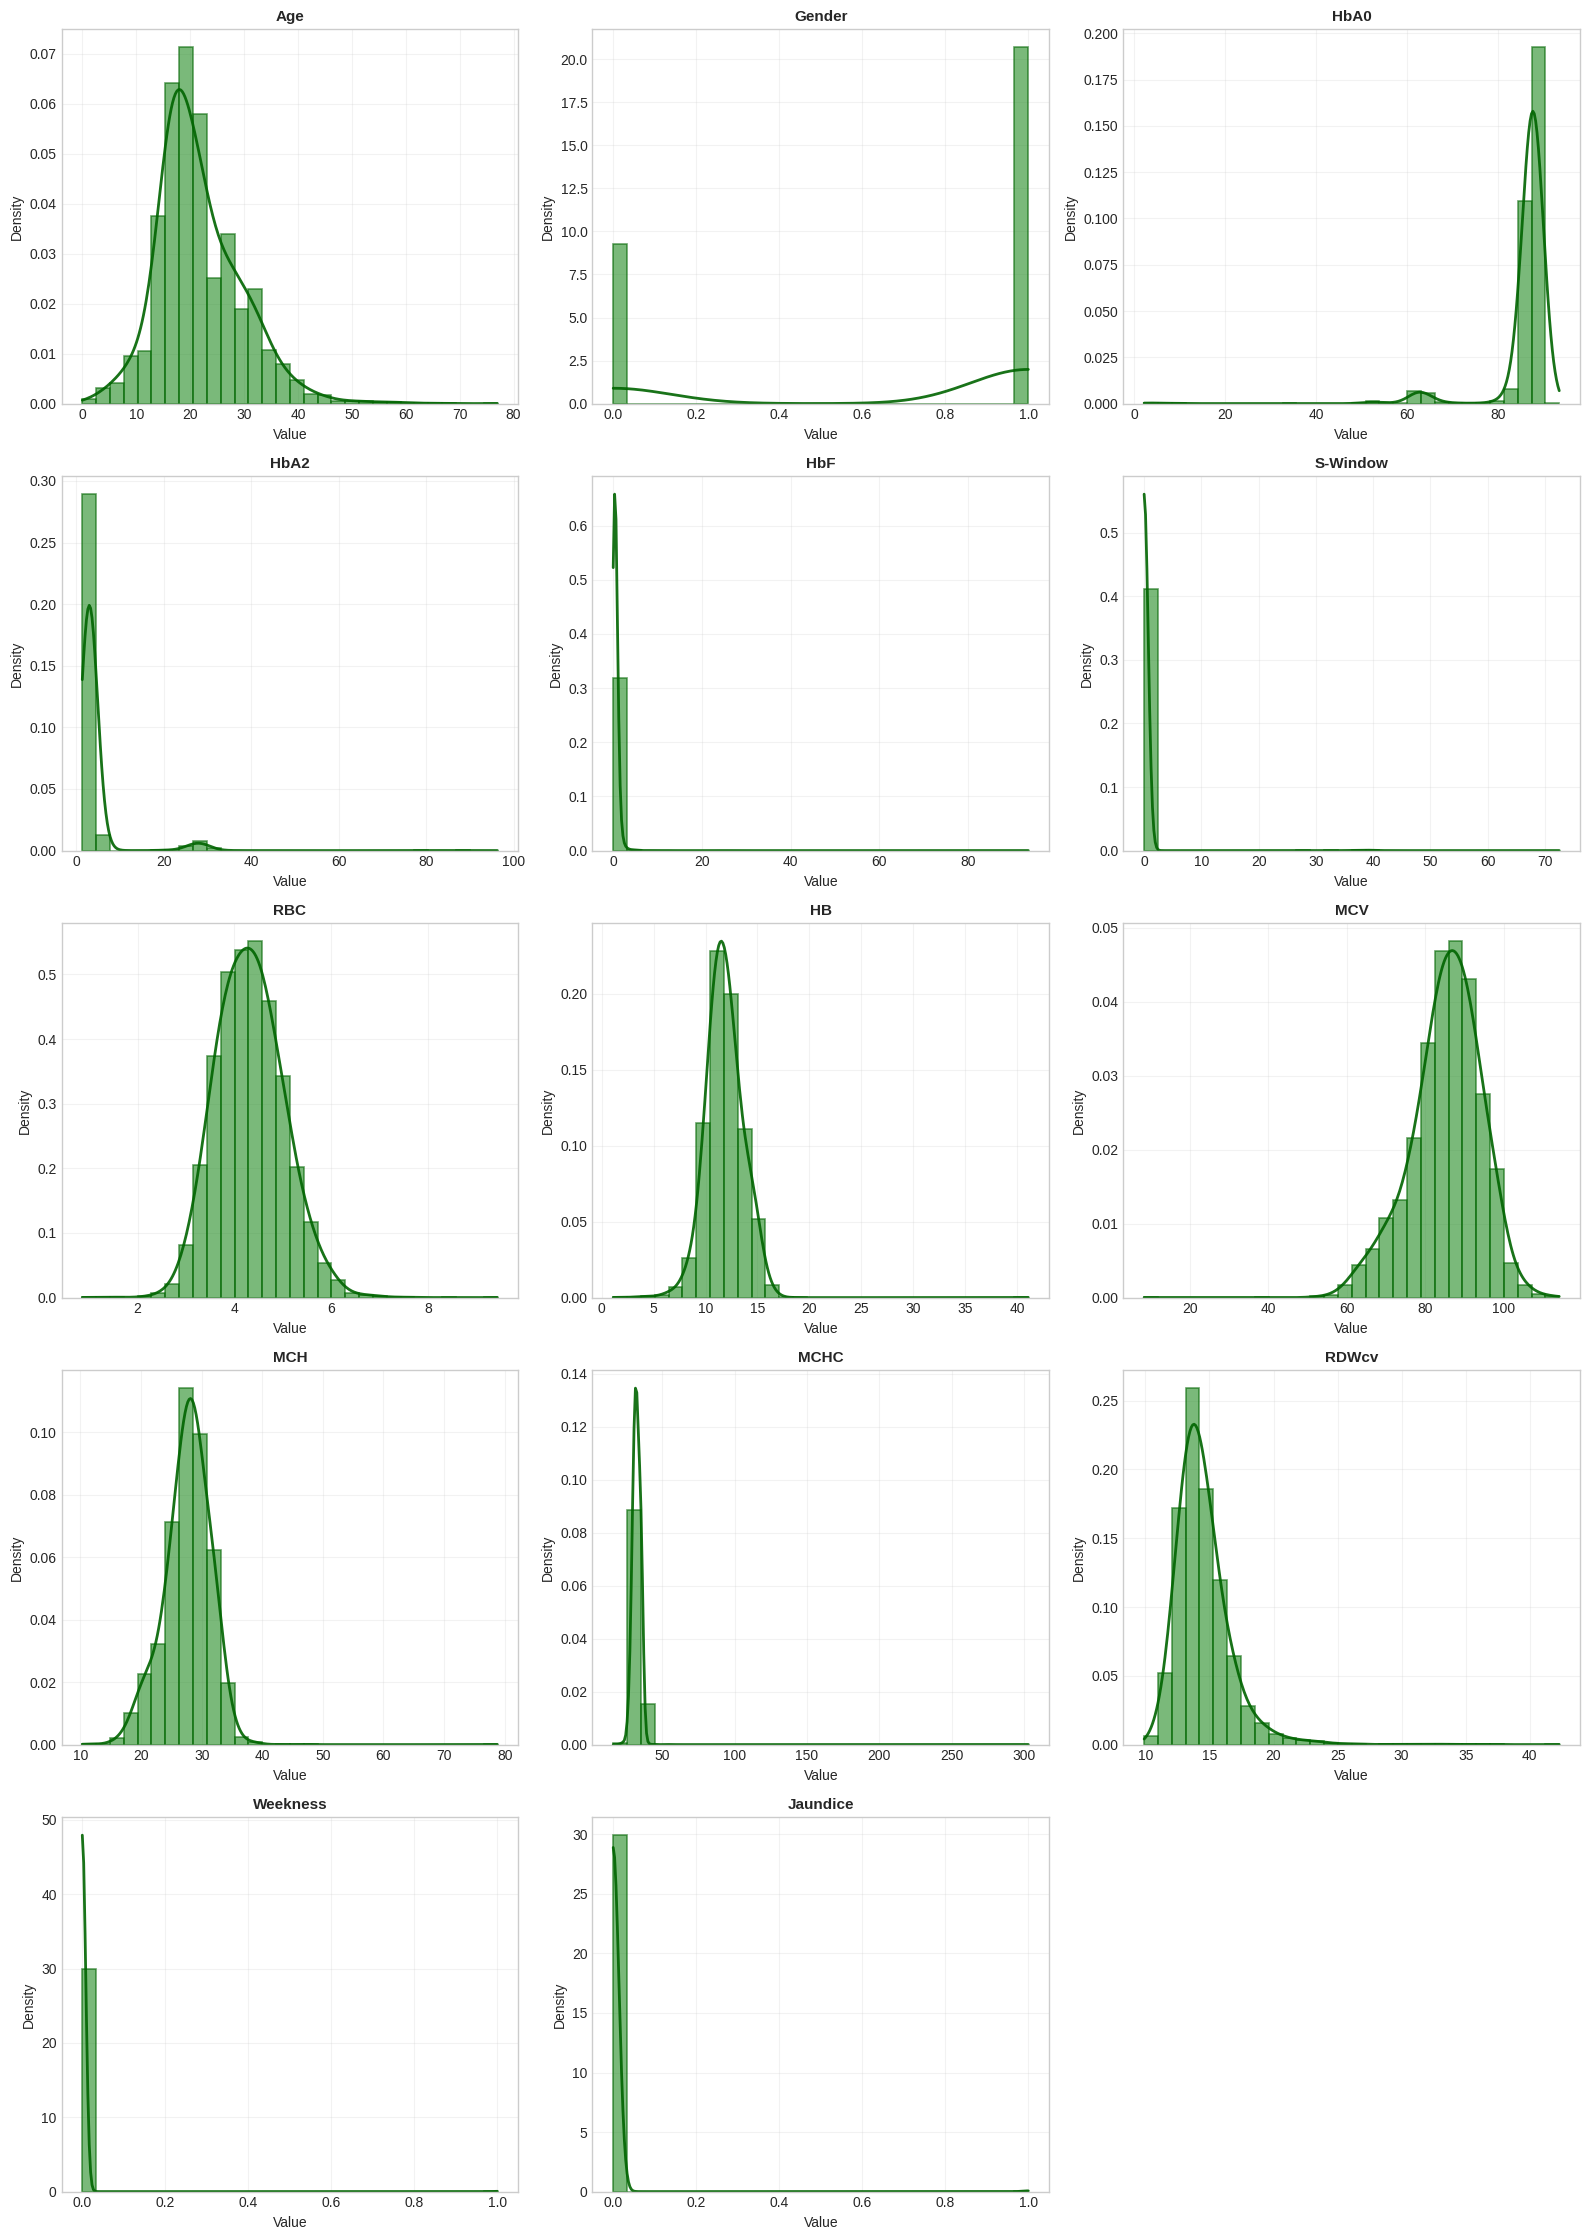

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import gaussian_kde

# ---------------- LOAD DATA ----------------
dataset = pd.read_csv("cleaned_dataset.csv")

X = dataset.drop('Diagnosis', axis=1)
y = dataset['Diagnosis']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

numeric_cols = X_train.select_dtypes(include=[np.number]).columns

# ---------------- PLOT SETTINGS ----------------
plt.style.use("seaborn-v0_8-whitegrid")

n_cols = 3
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

plt.figure(figsize=(16, 4.5 * n_rows))

# ---------------- HISTOGRAM + KDE ----------------
for i, col in enumerate(numeric_cols, 1):
    data = X_train[col].dropna()

    plt.subplot(n_rows, n_cols, i)

    # Adaptive bins
    bins = min(30, max(10, int(np.sqrt(len(data)))))

    # Histogram (Green, medium-thick border)
    plt.hist(
        data,
        bins=bins,
        density=True,
        alpha=0.6,
        color="forestgreen",
        edgecolor="darkgreen",
        linewidth=1.2  # medium thickness
    )

    # KDE (bold, smooth)
    kde = gaussian_kde(data, bw_method=0.3)
    x_vals = np.linspace(data.min(), data.max(), 300)
    plt.plot(
        x_vals,
        kde(x_vals),
        color="darkgreen",
        linewidth=2.0,  # bolder line for definition
        alpha=0.9
    )

    plt.title(col, fontsize=11, fontweight="bold")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.grid(alpha=0.25)

plt.tight_layout()
plt.show()


                   Age  Gender  HbA0  HbA2  HbF  S-Window   RBC    HB   MCV  \
0      14 Yrs 11 month       1  86.2   2.9  0.3       0.0  4.81  13.2  86.7   
1       16 Yrs 0 month       1  86.4   4.8  0.4       0.0  4.18  10.9  78.9   
2       16 Yrs 2 month       0  87.3   3.2  0.5       0.0  5.31  13.6  87.0   
3       21 Yrs 0 month       1  87.9   2.8  0.2       0.0  4.64  11.5  78.7   
4       35 Yrs 3 month       0  84.3   2.8  0.2       0.0  5.50  14.0  69.7   
...                ...     ...   ...   ...  ...       ...   ...   ...   ...   
13026    1 Yrs 0 month       0  79.3   2.9  5.8       0.0  2.07   6.1  89.4   
13027    1 Yrs 1 month       1  77.2   2.7  8.1       0.0  2.47   6.3  81.0   
13028   1 Yrs 11 month       0  21.3  62.9  5.2       0.0  5.26  10.0  60.3   
13029   1 Yrs 11 month       0  87.5   3.3  0.2       0.0  4.60  13.4  84.1   
13030   34 Yrs 3 month       0  88.9   3.2  0.3       0.0  2.97   9.8  91.9   

        MCH  MCHC  RDWcv  Weekness  Jaundice  Diagn

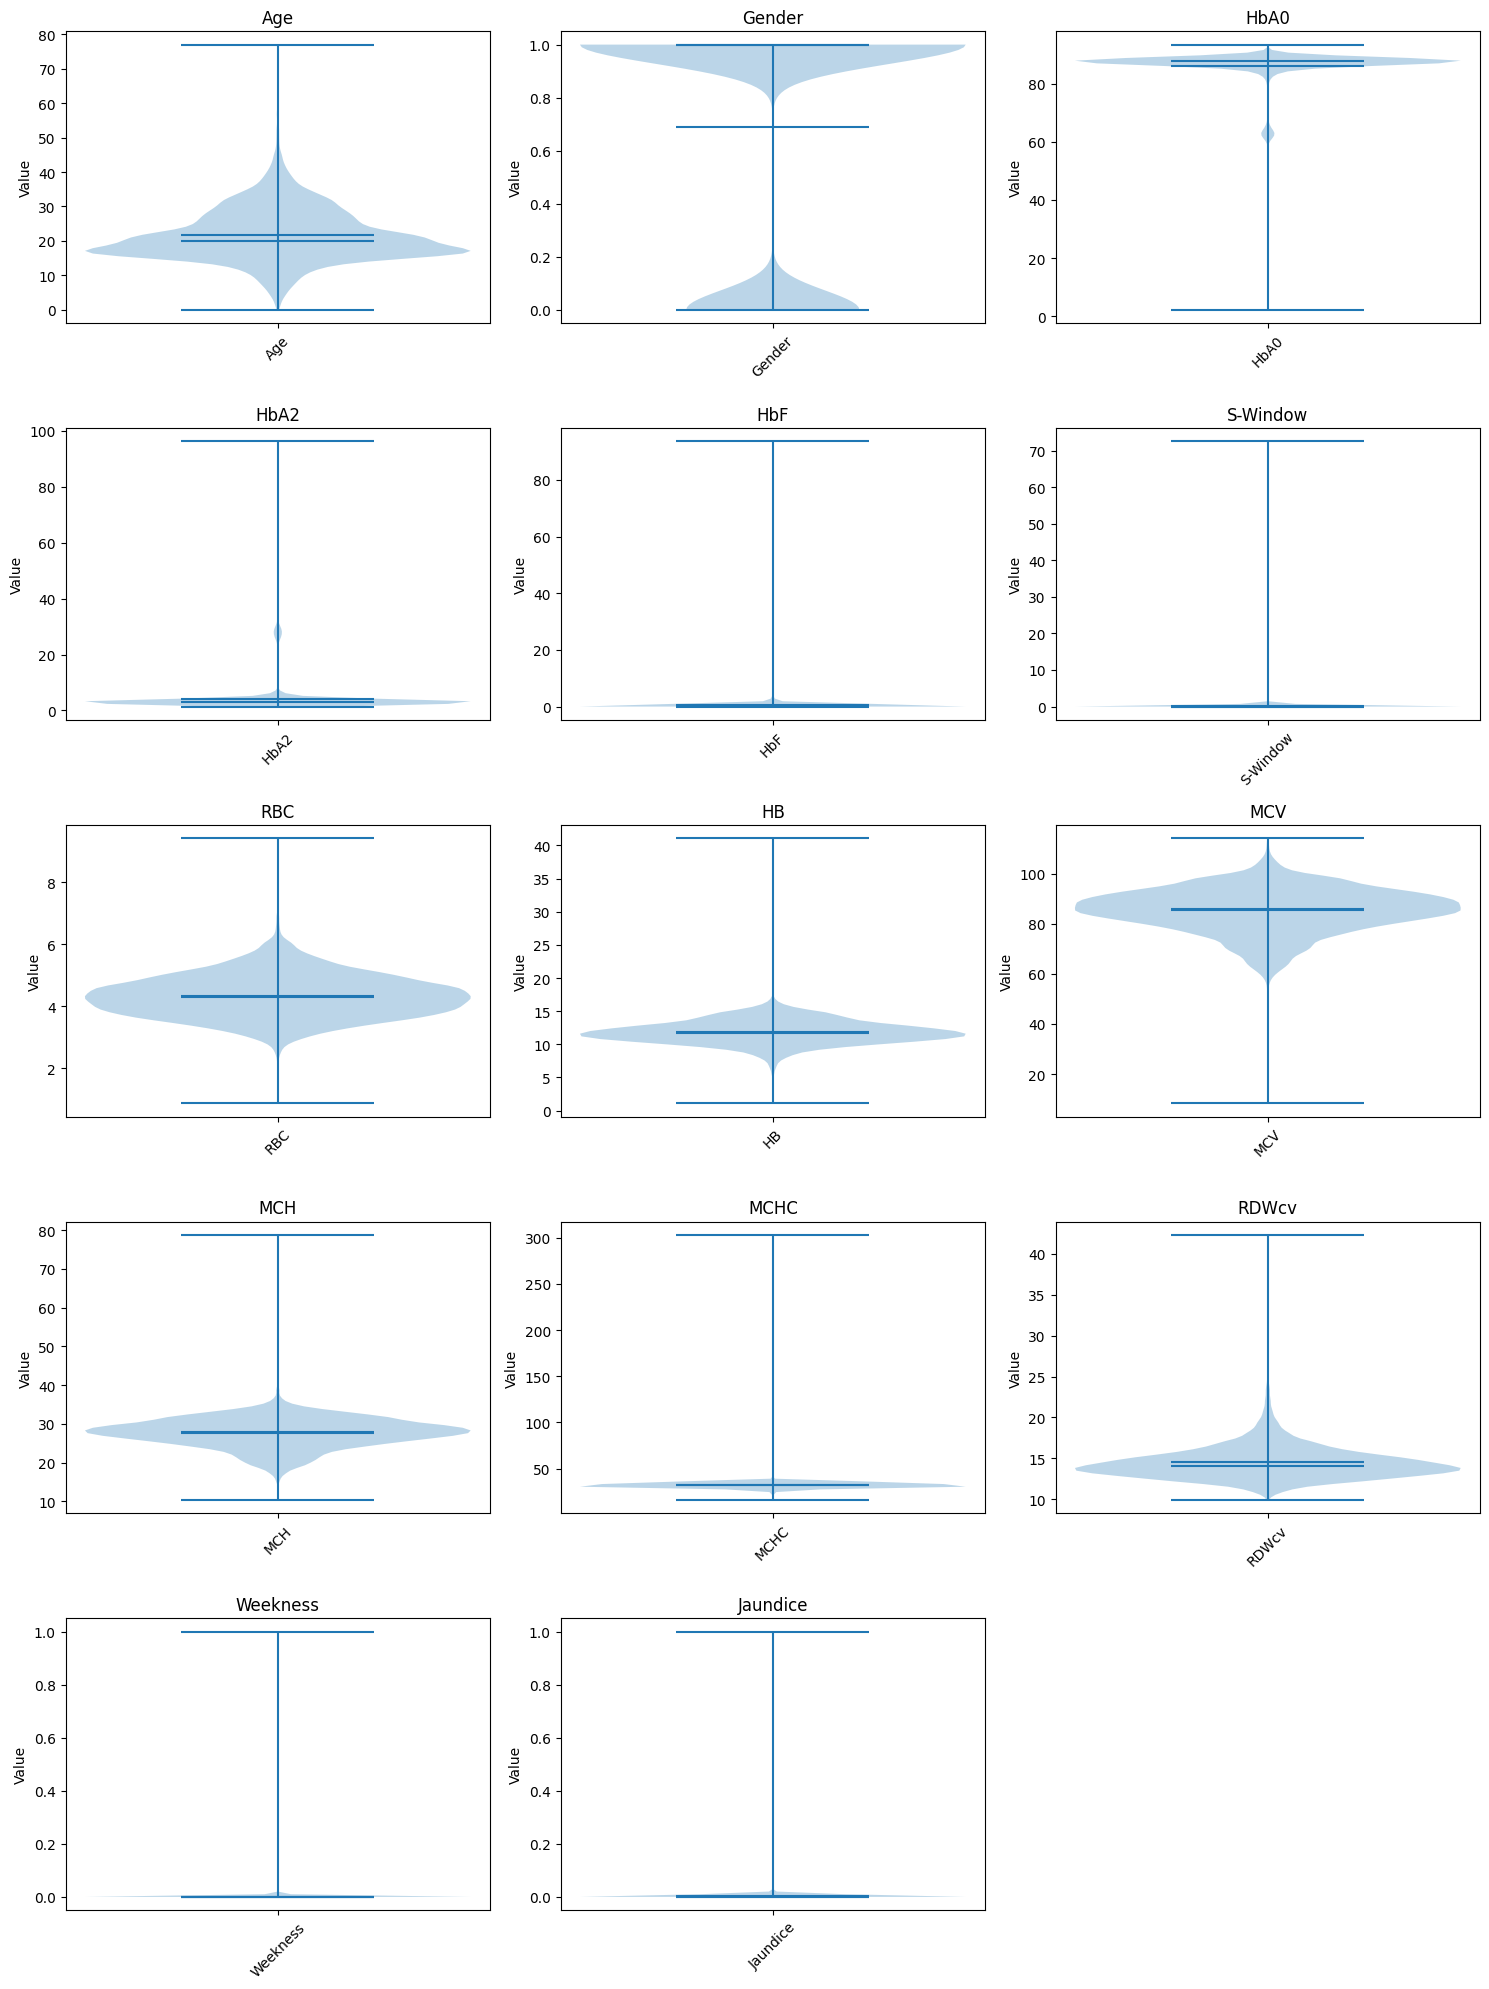

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load dataset
dataset = pd.read_csv("/content/thalassemia final dataset.csv")

dataset = dataset.drop(columns=['Sl No'])

print(dataset)


import pandas as pd
import re

# ---- Load your dataset ----
# dataset = pd.read_csv("your_file.csv")   # example

# Function to extract only years from mixed age strings
def extract_years(age_value):
    if pd.isna(age_value):
        return None
    age_str = str(age_value).lower()

    # Regex to capture only the year number
    match = re.search(r'(\d+)\s*(year|yr|years)?', age_str)
    if match:
        return int(match.group(1))
    return None

# ---- Apply function on Age column ----
dataset['Age'] = dataset['Age'].apply(extract_years)

# ---- If NaN exists, fill with median ----
dataset['Age'] = dataset['Age'].fillna(dataset['Age'].median())

# ---- Save new cleaned dataset ----
dataset.to_csv("cleaned_dataset.csv", index=False)

print("Dataset cleaned and saved as cleaned_dataset.csv")
dataset.head()

# Features and target
X = dataset.drop('Diagnosis', axis=1)
y = dataset['Diagnosis']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Numeric columns
numeric_cols = X_train.select_dtypes(include=[np.number]).columns

# Subplot grid
n_cols = 3
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

plt.figure(figsize=(15, 4 * n_rows))

for i, col in enumerate(numeric_cols, 1):
    data = X_train[col].dropna()

    plt.subplot(n_rows, n_cols, i)
    plt.violinplot(
        data,
        showmeans=True,
        showmedians=True,
        showextrema=True
    )

    plt.title(col)
    plt.ylabel("Value")
    plt.xticks([1], [col], rotation=45)

plt.tight_layout()
plt.show()


                   Age  Gender  HbA0  HbA2  HbF  S-Window   RBC    HB   MCV  \
0      14 Yrs 11 month       1  86.2   2.9  0.3       0.0  4.81  13.2  86.7   
1       16 Yrs 0 month       1  86.4   4.8  0.4       0.0  4.18  10.9  78.9   
2       16 Yrs 2 month       0  87.3   3.2  0.5       0.0  5.31  13.6  87.0   
3       21 Yrs 0 month       1  87.9   2.8  0.2       0.0  4.64  11.5  78.7   
4       35 Yrs 3 month       0  84.3   2.8  0.2       0.0  5.50  14.0  69.7   
...                ...     ...   ...   ...  ...       ...   ...   ...   ...   
13026    1 Yrs 0 month       0  79.3   2.9  5.8       0.0  2.07   6.1  89.4   
13027    1 Yrs 1 month       1  77.2   2.7  8.1       0.0  2.47   6.3  81.0   
13028   1 Yrs 11 month       0  21.3  62.9  5.2       0.0  5.26  10.0  60.3   
13029   1 Yrs 11 month       0  87.5   3.3  0.2       0.0  4.60  13.4  84.1   
13030   34 Yrs 3 month       0  88.9   3.2  0.3       0.0  2.97   9.8  91.9   

        MCH  MCHC  RDWcv  Weekness  Jaundice  Diagn

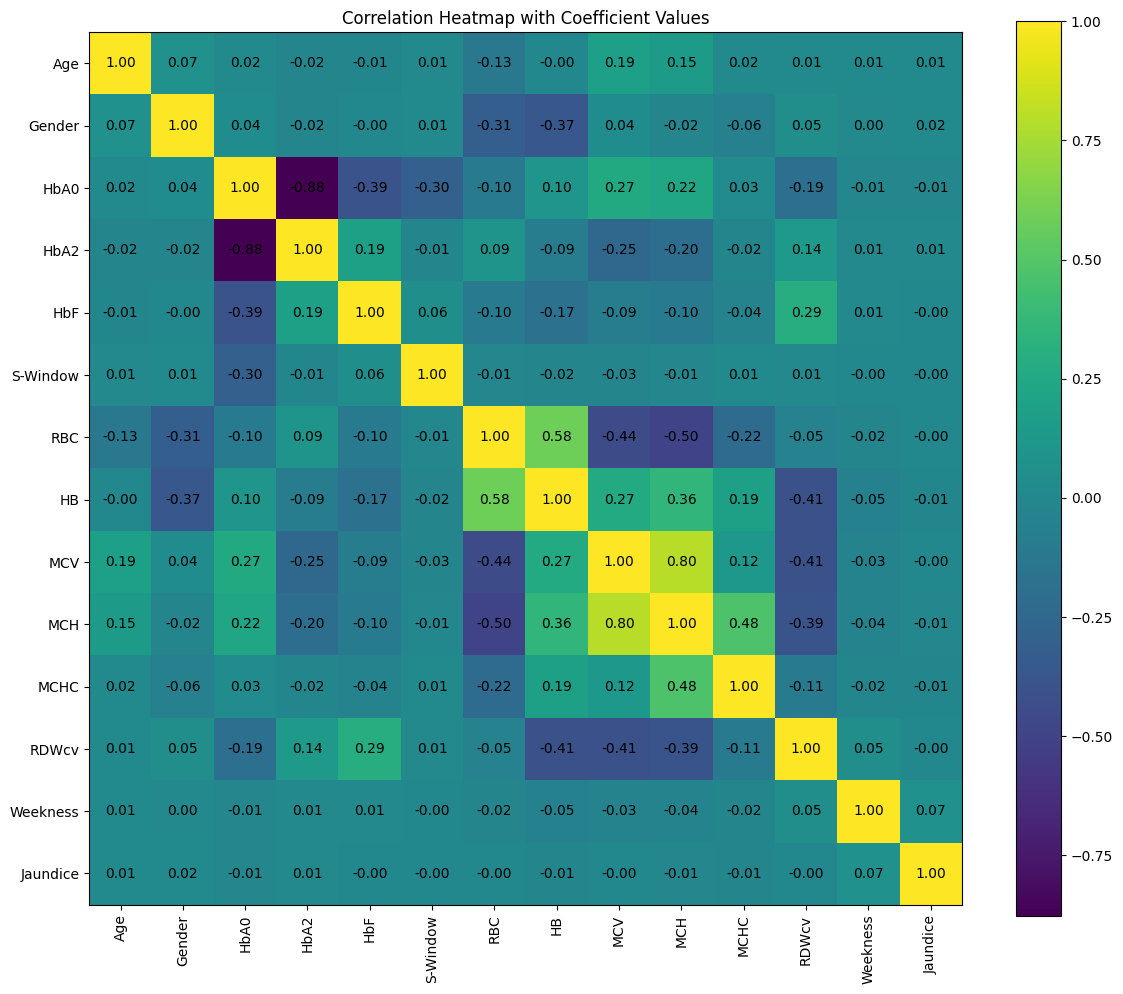

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load dataset
dataset = pd.read_csv("/content/thalassemia final dataset.csv")

dataset = dataset.drop(columns=['Sl No'])

print(dataset)

import pandas as pd
import re

# ---- Load your dataset ----
# dataset = pd.read_csv("your_file.csv")   # example

# Function to extract only years from mixed age strings
def extract_years(age_value):
    if pd.isna(age_value):
        return None
    age_str = str(age_value).lower()

    # Regex to capture only the year number
    match = re.search(r'(\d+)\s*(year|yr|years)?', age_str)
    if match:
        return int(match.group(1))
    return None

# ---- Apply function on Age column ----
dataset['Age'] = dataset['Age'].apply(extract_years)

# ---- If NaN exists, fill with median ----
dataset['Age'] = dataset['Age'].fillna(dataset['Age'].median())

# ---- Save new cleaned dataset ----
dataset.to_csv("cleaned_dataset.csv", index=False)

print("Dataset cleaned and saved as cleaned_dataset.csv")
dataset.head()


# Features and target
X = dataset.drop('Diagnosis', axis=1)
y = dataset['Diagnosis']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Correlation matrix
corr_matrix = X_train.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
im = plt.imshow(corr_matrix)

# Colorbar
plt.colorbar(im)

# Axis ticks
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)

# Add correlation values inside cells
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        value = corr_matrix.iloc[i, j]
        plt.text(j, i, f"{value:.2f}", ha="center", va="center")

plt.title("Correlation Heatmap with Coefficient Values")
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# ==============================
# Train–Test Split
# ==============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ==============================
# Train XGBoost Model
# ==============================
model = XGBClassifier(
    n_estimators=500,   # sir er moto
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss'
)

model.fit(X_train, y_train)

# ==============================
# ROC Curve Calculation
# ==============================
y_prob = model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# ==============================
# Plot ROC Curve (BIG IMAGE)
# ==============================
plt.figure(figsize=(8, 7))
plt.plot(fpr, tpr, linewidth=3, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', linewidth=2)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 10 11], got [ 1  2  3  4  5  6  8  9 10 11 12 13]